In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
import matplotlib
import matplotlib as mpl
import re
import geopandas
import cmocean

import dask
import os
import sys
sys.path.insert(0, '/net/fs11/d0/emfreese/BC-IRF/')
import utils
import plotting_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [14]:
countries = ['MALAYSIA','CAMBODIA','INDONESIA','VIETNAM']

## Add time dimension
days_per_year = 365

length_simulation = utils.years*days_per_year
time_array = np.arange(0, length_simulation)
shutdown_years = np.arange(2000,2061,1)

In [15]:
###### Import prepared plant data #######
CGP_df = pd.read_csv(f'{utils.data_output_path}plants/BC_SE_Asia_all_financing_SEA_GAINS_Springer_plus_rad.csv', index_col = [0])
min_year = CGP_df['Year_of_Commission'].min()
print('Emis data prepped and loaded')


######## Country mask and dataframe ######

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50
country_df = geopandas.read_file(f'{utils.raw_data_in_path}/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
impacted_countries = ['China','Australia', 'India','Myanmar', 'Cambodia', 'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan','Brunei','Papua New Guinea', 'Solomon Islands', 'East Timor', 'Taiwan', 'Malaysia', 'Vietnam','Indonesia'] 
country_df = country_df.rename(columns = {'SOVEREIGNT':'country'})

ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
utils.fix_area_ij_latlon(ds_area);


Emis data prepped and loaded


/tmp/ipykernel_3845749/167148032.py:9: UserWarning: `land_50` of `natural_earth_v4_1_0` and `natural_earth_v5_0_0` does not quite extend to 90°S - it's recommended to use `natural_earth_v5_1_2` instead. See https://github.com/regionmask/regionmask/issues/487
  country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50


In [48]:
for ct in ['INDONESIA','VIETNAM','CAMBODIA','MALAYSIA']:  
    print(ct, CGP_df.loc[CGP_df['COUNTRY'] == ct]['BC_(g/yr)'].sum()/1e6)

INDONESIA 329.49637260572456
VIETNAM 143.85449214909892
CAMBODIA 2.91256467552
MALAYSIA 64.73651513142859


In [53]:
for ct in ['INDONESIA','VIETNAM','CAMBODIA','MALAYSIA']:  
    print(ct, CGP_df.loc[CGP_df['COUNTRY'] == ct]['dt_sum'].mean())

INDONESIA 9.73643070110701e-09
VIETNAM 1.766784465714286e-08
CAMBODIA 4.724428166666667e-09
MALAYSIA 3.1607854e-08


In [24]:
total_ct_emis = {'CAMBODIA':.0219, 'VIETNAM': .3709, 'MALAYSIA': .2902,
'INDONESIA': .8122} 

In [ ]:
pd.DataFrame.from_dict(total_ct_emis, orient='index', columns=['co2_emissions'])

,co2_emissions
CAMBODIA,0.0219
VIETNAM,0.3709
MALAYSIA,0.2902
INDONESIA,0.8122


In [34]:
(pd.DataFrame(CGP_df.groupby('COUNTRY')['co2_emissions'].sum()/1e9)/pd.DataFrame.from_dict(total_ct_emis, orient='index', columns=['co2_emissions']))*100

,co2_emissions
CAMBODIA,14.062063
INDONESIA,38.296865
MALAYSIA,30.861734
VIETNAM,31.111223


In [4]:
GtC_per_TtC = 1e3
RTCRE = xr.open_dataset(f'{utils.raw_data_in_path}RTCRE.nc')['__xarray_dataarray_variable__'].sel(year = 70) * GtC_per_TtC #K/1000GtC 

In [5]:
def assign_rtcre(RTCRE, country_df, impacted_countries, area_weights=None):
    """
    Create a regionmask from your geopandas dataframe and use it for spatial averaging.
    Now includes proper area weighting using gradient-based grid cell area calculation.
    """
    import regionmask
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray
    
    # Filter country_df to only impacted countries
    filtered_countries = country_df[country_df['country'].isin(impacted_countries)].copy()
    
    # Dissolve duplicate countries to merge their geometries
    filtered_countries = filtered_countries.dissolve(by='country', as_index=False)
    
    # Create regionmask from the geopandas dataframe
    countries_mask = regionmask.from_geopandas(
        filtered_countries,
        names='country',
        abbrevs='country',
        name='countries'
    )
    
    # Create mask over RTCRE grid
    mask = countries_mask.mask(RTCRE, wrap_lon=True)
    
    # Calculate proper area weights if not provided
    if area_weights is None:
        lat = RTCRE.lat.values
        lon = RTCRE.lon.values
        
        # Create coordinate grids
        xlon, ylat = meshgrid(lon, lat)
        
        # Earth radius (can be constant or latitude-dependent)
        R = 6371  # Earth radius in km (constant approximation)
        
        # Calculate gradients (grid spacing) at each point
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
        
        # Calculate dx and dy in km
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
        
        # Calculate area of each grid cell
        area = dy * dx
        
        # Convert to xarray DataArray with same coordinates as RTCRE
        area_weights = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
                "description": "Grid cell area",
                "units": "m^2",
            },
        )
    
    country_rtcre = {}
    
    for country in impacted_countries:
        try:
            # Find the region number for this country
            region_number = None
            for region in countries_mask:  
                if region.name == country:
                    region_number = region.number
                    break
            
            if region_number is None:
                print(f"Country {country} not found in mask")
                continue
            
            # Create country mask
            country_mask_bool = (mask == region_number)
            
            # Apply mask to both RTCRE and area weights
            country_data = RTCRE.where(country_mask_bool)
            country_weights = area_weights.where(country_mask_bool)
            
            # Calculate area-weighted mean
            weighted_sum = (country_data * country_weights).sum(skipna=True)
            weight_sum = country_weights.sum(skipna=True)
            
            if weight_sum > 0:
                country_mean = (weighted_sum / weight_sum).values.item()
            else:
                country_mean = np.nan
                
            country_rtcre[country] = country_mean
            
        except Exception as e:
            print(f"Error processing {country}: {e}")
            country_rtcre[country] = np.nan
    
    return area_weights, country_rtcre

In [6]:

area_weights, country_rtcre_values = assign_rtcre(RTCRE, country_df, impacted_countries)


In [7]:
ARTP = pd.read_csv(f'{utils.data_output_path}/ARTP_processed.csv')
#take mean across winter and summer, assuming each season is 50% of the forcing
ARTP = ARTP.groupby(['Location','t_horizon',]).mean('Emis_season')

In [8]:
# Multiply the ARTP by the emissions
lhs  = pd.DataFrame(CGP_df['BC_(g/yr)'])
ARTP.index = ['{}_{}'.format(i, j) for i, j in ARTP.index]
rhs = pd.DataFrame(ARTP.transpose())
empty_df = pd.DataFrame(data = None, index = lhs.index, columns = rhs.columns).fillna(1)
k_em = empty_df*rhs.loc['BC_K_g']
em_yr = (empty_df.transpose()* lhs.transpose().loc['BC_(g/yr)']).transpose()
k_g = k_em*em_yr

/tmp/ipykernel_3474457/2767321851.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_df = pd.DataFrame(data = None, index = lhs.index, columns = rhs.columns).fillna(1)


In [9]:
## Get the warming values and combine with our emissions data
# Function to extract number from column name
def get_number_from_column(col_name):
    match = re.search(r'_(\d+)$', col_name)  
    if match:
        return int(match.group(1))
    return None


# Iterate through columns and divide by number if found
for col in k_g.columns:
    number = get_number_from_column(col)
    if number is not None:
        k_g[col] = k_g[col] / number

In [10]:
CGP_df = pd.concat([CGP_df, k_g], axis = 1)

In [11]:
#calculate the years of operation, emissions for that amount of time, and radiative forcing over that time for all plants (if they are running for up to 40 years or less)
E_CO2_all_opts = {}

#for each early shutdown year
for yr in shutdown_years:
    #calculate the years until shutdown for each plant
    E_CO2_all_opts[yr] = ((yr- CGP_df.loc[(CGP_df['BC_(g/yr)'] >0)]['Year_of_Commission'] ))
    #make datasets
    E_CO2_all_opts[yr] = xr.DataArray(data = E_CO2_all_opts[yr].values,
                                dims = ['unique_ID'],
                                coords = dict(unique_ID = 
                                              CGP_df.loc[(CGP_df['BC_(g/yr)'] >0)].index),
                                attrs = dict(description = 'years that each power plant operates under a given early shutdown',
                                            units = 'yrs'))
    

    #make sure the plants are operating, and that they don't exceed their lifetime (estimated 40 years)
    E_CO2_all_opts[yr] = E_CO2_all_opts[yr].where(E_CO2_all_opts[yr] > 0).fillna(0)
    E_CO2_all_opts[yr] = E_CO2_all_opts[yr].where(E_CO2_all_opts[yr] <= 40).fillna(40)

#concatenate into a dataset
shutdown_ds= xr.concat([E_CO2_all_opts[m] for m in E_CO2_all_opts.keys()], pd.Index([m for m in E_CO2_all_opts.keys()], name='scenario_year'), join = 'outer')


In [12]:
shutdown_single_yr_ds = xr.ones_like(shutdown_ds)

In [13]:
country_id_ds = CGP_df.loc[CGP_df['BC_(g/yr)'] >0].groupby('unique_ID').first().to_xarray() 

In [14]:
ug_to_ng = 1e3

for c in countries:
    for unique_id in CGP_df.loc[(CGP_df['COUNTRY'] == c) & (CGP_df['BC_(g/yr)'] >0)]['unique_ID'].values:
        print(c, unique_id)

In [15]:
### import the convolutions 
conv_df = {}
for c in countries:
    for unique_id in CGP_df.loc[(CGP_df['COUNTRY'] == c) & (CGP_df['BC_(g/yr)'] >0)]['unique_ID'].values:
        path = f'{utils.data_output_path}convolution/convolution_{c}_{unique_id}_uniqueid.nc'
        if os.path.exists(path):
            conv_df[unique_id] = pd.read_csv(path, index_col = 0)
            conv_df[unique_id] = conv_df[unique_id].to_xarray().rename({'index':'country_impacted'})
        else:
            print(f'missing {c} {unique_id}')


# Concatenate all the convolution dataframes into a single xarray dataset   
conv_ds = xr.concat([conv_df[t] for t in conv_df.keys()], pd.Index([t for t in conv_df.keys()], name='unique_ID'), join = 'outer')#*ug_to_ng

In [16]:
conv_ds = conv_ds.where(conv_ds['country_impacted'].isin(impacted_countries), drop = 'True')      #ensure there is no duplication of countries  

conv_ds = conv_ds.drop_duplicates(dim='country_impacted')

In [17]:
### Name the datasets and add attributes        
shutdown_ds.name = 'plants_shutdown'
shutdown_single_yr_ds.name = 'remaining_plants'

shutdown_ds.attrs['units'] = 'none'
shutdown_single_yr_ds.attrs['units'] = 'none'

In [18]:
### rename variables to be more readable  

def is_string_dtype(dtype):
    return dtype.kind in {'U', 'S', 'O', 'i'}

# Select non-string variables
non_string_vars = {var: country_id_ds[var] for var in country_id_ds.data_vars 
                   if not is_string_dtype(country_id_ds[var].dtype)}      
reduced_id_ds = country_id_ds[non_string_vars.keys()]

In [19]:
### Remove some variables that are repeats
var_drop_list = ['Unnamed:_0', 'UNITID', 'UNIT', 'PLANT', 'COMPANY', 'MW', 
                 'STATUS', 'Year_of_Commission', 'UTYPE', 'FUEL', 'FUELTYPE', 
                 'ALTFUEL', 'SSSMFR', 'BOILTYPE', 'TURBMFR', 'TURBTYPE', 'GENMFR', 
                 'GENTYPE', 'SFLOW', 'SPRESS', 'STYPE', 'STEMP', 'REHEAT1', 'REHEAT2', 
                 'PARTCTL', 'PART.BAT', 'PARTMFR', 'SO2CTL', 'SO2.BAT', 'FGDMFR', 'NOXCTL', 'NOX.BAT', 
                 'NOXMFR', 'AE', 'AE.COUNTRY', 'AE.CHINA', 'CONSTRUCT', 'CON.COUNTRY', 'CON.CHINA', 'COOL', 
                 'RETIRE', 'CITY', 'STATE', 'AREA', 'SUBREGION', 'POSTCODE', 'PARENT', 'PAR.COUNTRY', 
                 'PAR.CHINA', 'ELECTYPE', 'BUSTYPE', 'COMPID', 'LOCATIONID', 'HEATRATE.UNADJ', 
                 'CO2_weighted_capacity_1000tonsperMW', 'CAPFACTOR', 'ANNUALCO2', 'EMISFACTOR.GCPT', 
                 'HEATRATE.ADJ', 'COAL', 'EMISFACTOR.CO2', 'HEATRATE', 'EMISFACTOR.BC.GAINS', 
                 'EMISFACTOR.BC.GAINS.g_mwh', 'MWh_daily', 'location_key', 'latitude', 'longitude', 
                 'grid_area_m2']

In [20]:
#multiple the timeline datasets and convolutions by the emissions/radiation datasets, this will give us the cumulative amount
vars_ds = shutdown_ds*reduced_id_ds

#single year impact
vars_single_ds = shutdown_single_yr_ds*reduced_id_ds

#multiply the convolution
conv_shutdown_ds = conv_ds * shutdown_ds
conv_single_ds = conv_ds * shutdown_single_yr_ds

# drop the variables that are not needed if they are in the var_ds or vars_single_ds
var_ds_drop = [var for var in var_drop_list if var in vars_ds.data_vars]
vars_ds = vars_ds.drop(var_ds_drop)

#create a single year impact
vars_single_ds_drop = [var for var in var_drop_list if var in vars_single_ds.data_vars]
vars_single_ds = vars_single_ds.drop(vars_single_ds_drop)

/tmp/ipykernel_3474457/1136870500.py:13: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  vars_ds = vars_ds.drop(var_ds_drop)
/tmp/ipykernel_3474457/1136870500.py:17: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  vars_single_ds = vars_single_ds.drop(vars_single_ds_drop)


rad_force_ds = country_id_ds['rad_forcing_wperm2perkg']*Emis_ds

k_per_tg_per_yr = 0.04 #https://acp-copernicus-org.libproxy.mit.edu/articles/20/3079/2020/ Sand et al.
temp_ds = Emis_ds/Tg_per_kg

conv_dsrad_force_ds.name = 'BC_forcing'
rad_force_ds.attrs = {'units':'W/m2'}

temp_ds.name = 'BC_temp'
temp_ds.attrs = {'units':'K'} 

In [21]:
# Create a merged dataset
scenario_ds = xr.merge([country_id_ds.drop(['co2_emissions',  'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)', 'bc_emission_kg_m2_sec', 'BC_(kg/m2/year)', 'sum_rf_toa', 'dt_sum',
                                                'Global_10',
                                                'Global_20',
                                                'Global_50',
                                                'Global_100',
                                                'N_arctic_10',
                                                'N_arctic_20',
                                                'N_arctic_50',
                                                'N_arctic_100',
                                                'N_midlat_10',
                                                'N_midlat_20',
                                                'N_midlat_50',
                                                'N_midlat_100',
                                                'S_subtropics_10',
                                                'S_subtropics_20',
                                                'S_subtropics_50',
                                                'S_subtropics_100',
                                                'Tropics_10',
                                                'Tropics_20',
                                                'Tropics_50',
                                                'Tropics_100']).rename({'MW_total':'MW'}), 
                    vars_ds, 
                    conv_shutdown_ds]).rename({'COUNTRY':'country_emitting'})



# Create a merged dataset for single year data
single_year_ds = xr.merge([country_id_ds.drop(['co2_emissions', 'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)', 'bc_emission_kg_m2_sec', 'BC_(kg/m2/year)', 'sum_rf_toa', 'dt_sum',
                                                'Global_10',
                                                'Global_20',
                                                'Global_50',
                                                'Global_100',
                                                'N_arctic_10',
                                                'N_arctic_20',
                                                'N_arctic_50',
                                                'N_arctic_100',
                                                'N_midlat_10',
                                                'N_midlat_20',
                                                'N_midlat_50',
                                                'N_midlat_100',
                                                'S_subtropics_10',
                                                'S_subtropics_20',
                                                'S_subtropics_50',
                                                'S_subtropics_100',
                                                'Tropics_10',
                                                'Tropics_20',
                                                'Tropics_50',
                                                'Tropics_100']).rename({'MW_total':'MW'}), 
                    vars_single_ds, 
                    conv_single_ds]).rename({'COUNTRY':'country_emitting'})


/tmp/ipykernel_3474457/3170991850.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  scenario_ds = xr.merge([country_id_ds.drop(['co2_emissions',  'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)', 'bc_emission_kg_m2_sec', 'BC_(kg/m2/year)', 'sum_rf_toa', 'dt_sum',
/tmp/ipykernel_3474457/3170991850.py:29: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  single_year_ds = xr.merge([country_id_ds.drop(['co2_emissions', 'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)', 'bc_emission_kg_m2_sec', 'BC_(kg/m2/year)', 'sum_rf_toa', 'dt_sum',


##### Convert to Geopandas Dataframe for mapping

In [22]:
gdf = country_df[country_df['country'].isin(impacted_countries)][['country','geometry']].rename(columns = {'country':'country_impacted'}).set_index('country_impacted')

In [23]:
map_locations = ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM', 'all']
shutdown_years = np.arange(2030, 2060, 10)

# Without normalization
regular_data = plotting_utils.prepare_concentration_data(
    scenario_ds, gdf,
    map_locations, 
    shutdown_years,
    variable = ['BC_pop_weight_mean_conc', 'BC_surface_mean_conc', 'BC_column_mean_conc' ]

)

# With normalization
normalized_data = plotting_utils.prepare_concentration_data(
    scenario_ds, gdf,
    map_locations, 
    shutdown_years,
    variable = ['BC_pop_weight_mean_conc', 'BC_surface_mean_conc', 'BC_column_mean_conc' ],
    normalize=True,
    emissions_df=CGP_df  # Pass the emissions dataframe
)


##### Prepare the temperature relationship for each receiving country


In [24]:
# Get the centroid latitude for each impacted country
country_latitudes = {}

# Extract latitude from country_df which already has the geometries
for _, row in country_df[country_df['country'].isin(impacted_countries) & country_df['ADMIN'].isin(impacted_countries)].iterrows():
    # Calculate the centroid of the country's geometry
    centroid = row['geometry'].centroid
    country_latitudes[row['country']] = centroid.y


dict_latitudes_region = {'N_arctic': [60,90], 'N_midlat': [28,60], 'Tropics': [-28,28], 'S_subtropics': [-90,-28]}


# Function to determine which region a latitude belongs to
def get_latitude_region(latitude, region_dict):
    for region_name, lat_range in region_dict.items():
        min_lat, max_lat = lat_range
        if min_lat <= latitude <= max_lat:
            return region_name
    return None  # Return None if latitude doesn't fall within any defined region


# Map each country to its region based on its latitude
country_to_region = {}
for country, latitude in country_latitudes.items():
    region = get_latitude_region(latitude, dict_latitudes_region)
    country_to_region[country] = region

regions_vars_dict = {}
for region in list(dict_latitudes_region.keys()):  # Use keys instead of values
    regions_vars_dict[region] = [var for var in scenario_ds.data_vars 
                if region in var]
    


for yy in [10, 20, 50, 100]:
    single_year_ds[f'temperature_impact_aamaas_{yy}'] = xr.zeros_like(single_year_ds['BC_pop_weight_mean_conc'])
    for country in single_year_ds.country_impacted.values:
        single_year_ds[f'temperature_impact_aamaas_{yy}'].loc[dict(country_impacted=country)] = single_year_ds.loc[dict(country_impacted =country)][[country_to_region[country]][0] + f'_{yy}']

    scenario_ds[f'temperature_impact_aamaas_{yy}'] = xr.zeros_like(scenario_ds['BC_pop_weight_mean_conc'])
    for country in scenario_ds.country_impacted.values:
        scenario_ds[f'temperature_impact_aamaas_{yy}'].loc[dict(country_impacted=country)] = scenario_ds.loc[dict(country_impacted =country)][[country_to_region[country]][0] + f'_{yy}']



map_locations = ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM', 'all']
shutdown_years = np.arange(2030, 2060, 10)
temp_data = {}
normalized_temp_data = {}

for yy in [10, 20, 50, 100]:    

    # Without normalization
    temp_data[yy] = plotting_utils.prepare_concentration_data(
        scenario_ds, gdf,
        map_locations, 
        shutdown_years,
        variable = f'temperature_impact_aamaas_{yy}'
    )

    # With normalization
    normalized_temp_data[yy] = plotting_utils.prepare_concentration_data(
        scenario_ds, gdf,
        map_locations, 
        shutdown_years,
        variable = f'temperature_impact_aamaas_{yy}',
        normalize=True,
        emissions_df=CGP_df  # Pass your emissions dataframe
    )



In [25]:

for var in ['drf_toa', 'snowrf_toa', 'sum_rf_toa', 'dt_drf',
       'dt_snowrf', 'dt_sum']:
    # Without normalization
    temp_data[var] = plotting_utils.prepare_concentration_data(
        scenario_ds, gdf,
        map_locations, 
        shutdown_years,
        variable = var
    )

    # With normalization
    normalized_temp_data[var] = plotting_utils.prepare_concentration_data(
        scenario_ds, gdf,
        map_locations, 
        shutdown_years,
        variable = var,
        normalize=True,
        emissions_df=CGP_df  # Pass your emissions dataframe
    )


## Maps

In [44]:

# Plot regular data
fig1, axes1 = plotting_utils.plot_concentration_maps(
    regular_data, 
    map_locations, 
    shutdown_years,
    impacted_countries,
    country_df,
    variable='BC_pop_weight_mean_conc',
    save_path = '../figures/paper/maps/BC_concentration_maps.png'

)
plt.close(fig1)

# Plot normalized data
fig2, axes2 = plotting_utils.plot_concentration_maps(
    normalized_data, 
    map_locations, 
    shutdown_years,
    impacted_countries,
    country_df,
    variable='BC_pop_weight_mean_conc',
    vmin=1e-15,  
    vmax=1e-10,
    save_path = '../figures/paper/maps/BC_concentration_maps_normalized.png'
)
plt.close(fig2)

In [ ]:
yr = 2040
plotting_utils.plot_single_year_concentration_maps(
    regular_data,
    normalized_data, 
    map_locations, 
    yr,
    impacted_countries,
    country_df,
    variable='BC_surface_mean_conc',
    vmin_regular=1e-6, vmax_regular=1e-1,
    vmin_norm=1e-15,  
    vmax_norm=1e-10,
    save_path = f'../figures/paper/maps/BC_concentration_maps_normalized_regular_{yr}.png'
);
plt.close('all')

## Matrices related to maps

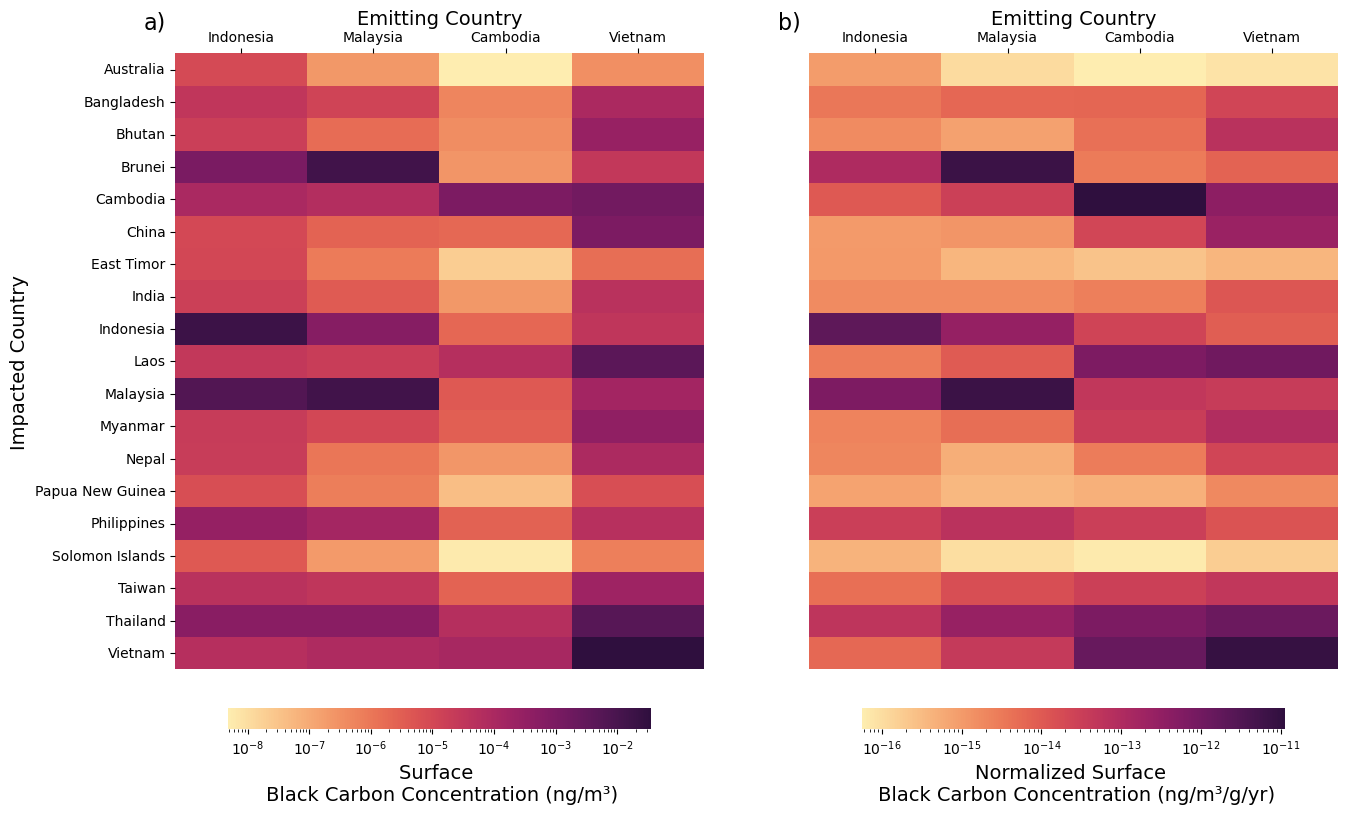

In [30]:
for year in [2040]:
    variable = 'BC_surface_mean_conc'
    # Get regular matrix data
    matrix_regular = plotting_utils.prep_matrix_from_scenario_ds(scenario_ds, year, variable, normalized=False)

    # Get normalized matrix data
    matrix_normalized = plotting_utils.prep_matrix_from_scenario_ds(scenario_ds, year, variable, normalized=True)

    variable='BC_surface_mean_conc' 
                                                
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,10])


    # Plot regular data on left subplot
    plotting_utils.plot_single_matrix(matrix_regular, ax1, variable, title_suffix = 'Regular')

    # Plot normalized data on right subplot  
    plotting_utils.plot_single_matrix(matrix_normalized, ax2, variable, title_suffix='Normalized by Emissions')

    # Labels and title
    ax1.set_xlabel('Emitting Country', fontsize=14)
    ax2.set_xlabel('Emitting Country', fontsize=14)
    ax1.set_ylabel('Impacted Country', fontsize=14)
    ax2.set_yticks([])    


    # Add subplot labels using a loop
    axes = [ax1, ax2]
    labels = ['a)', 'b)']
    
    for ax, label in zip(axes, labels):
        ax.text(-0.06, 1.07, label, transform=ax.transAxes, fontsize=16, 
                 verticalalignment='top')


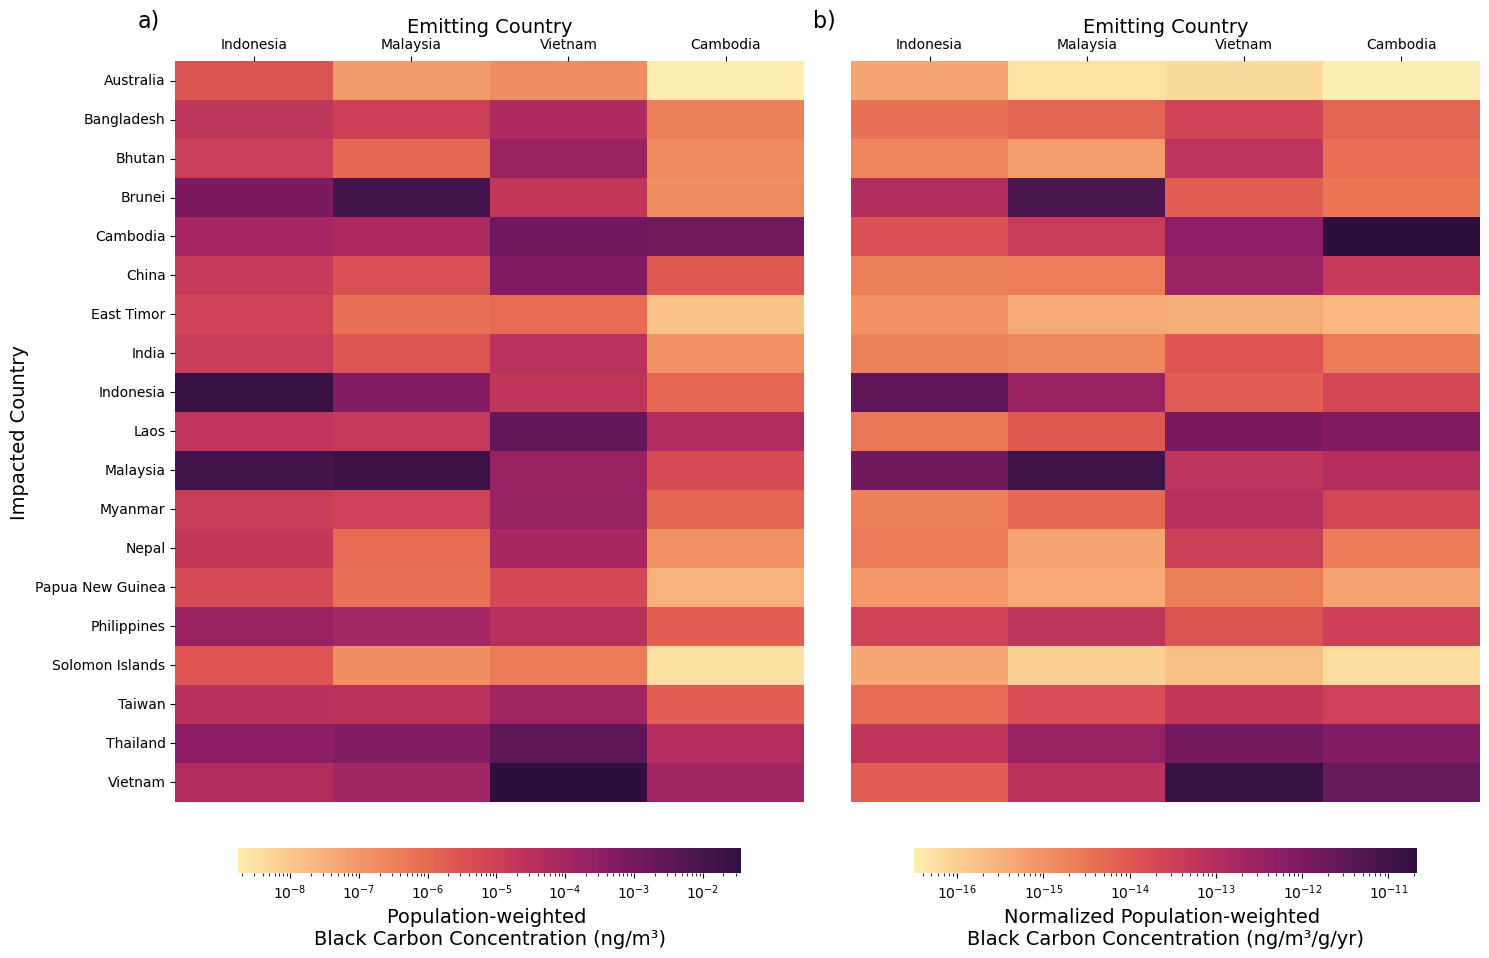

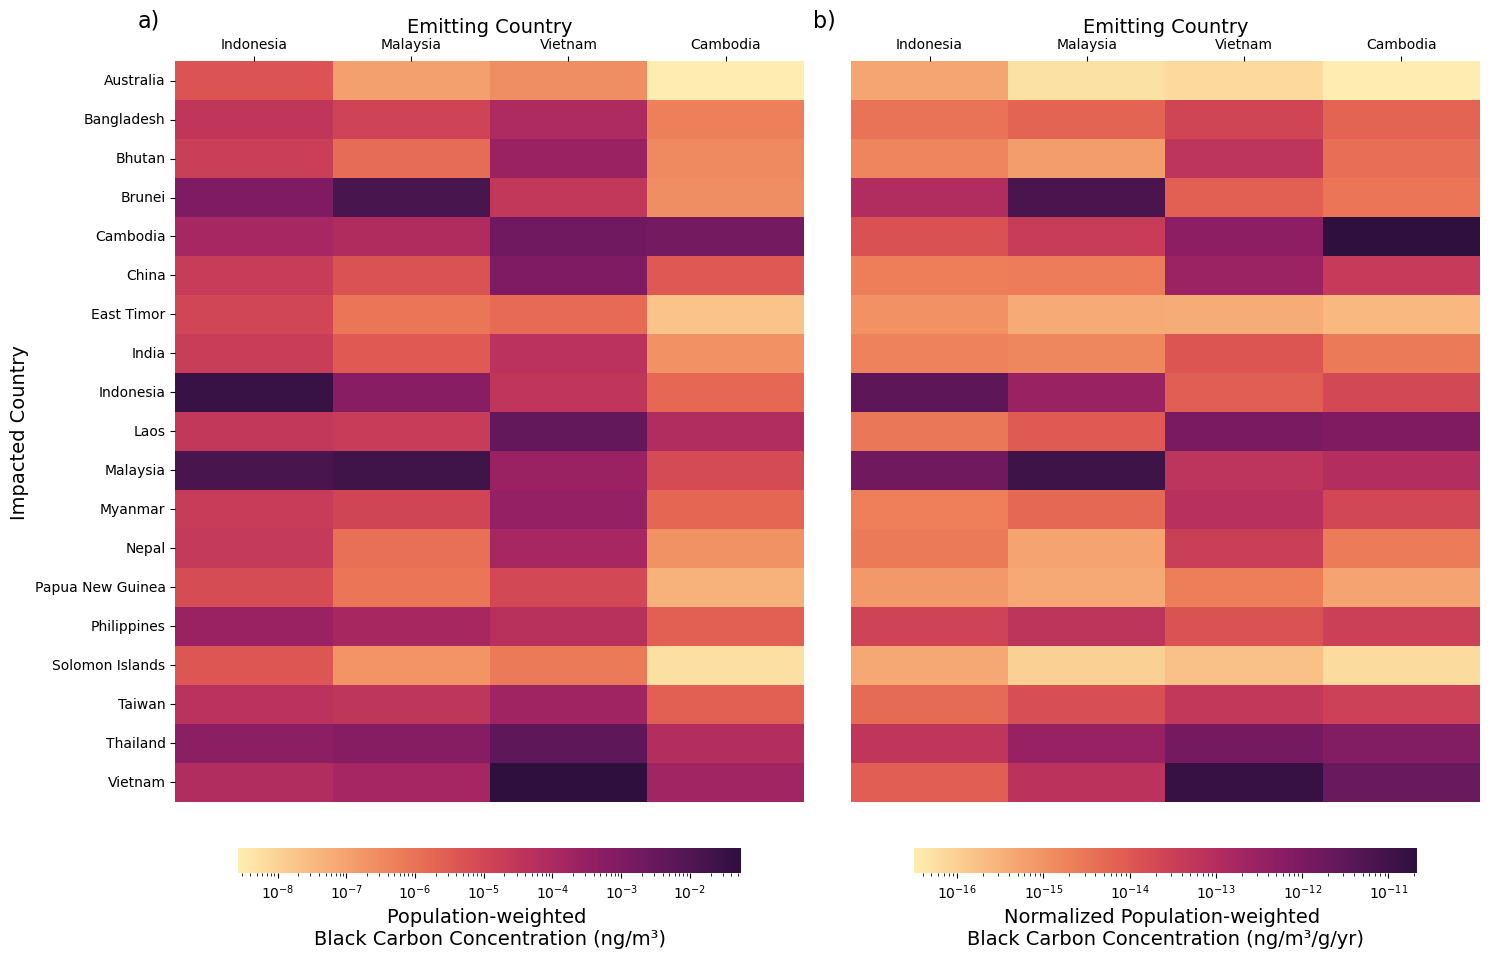

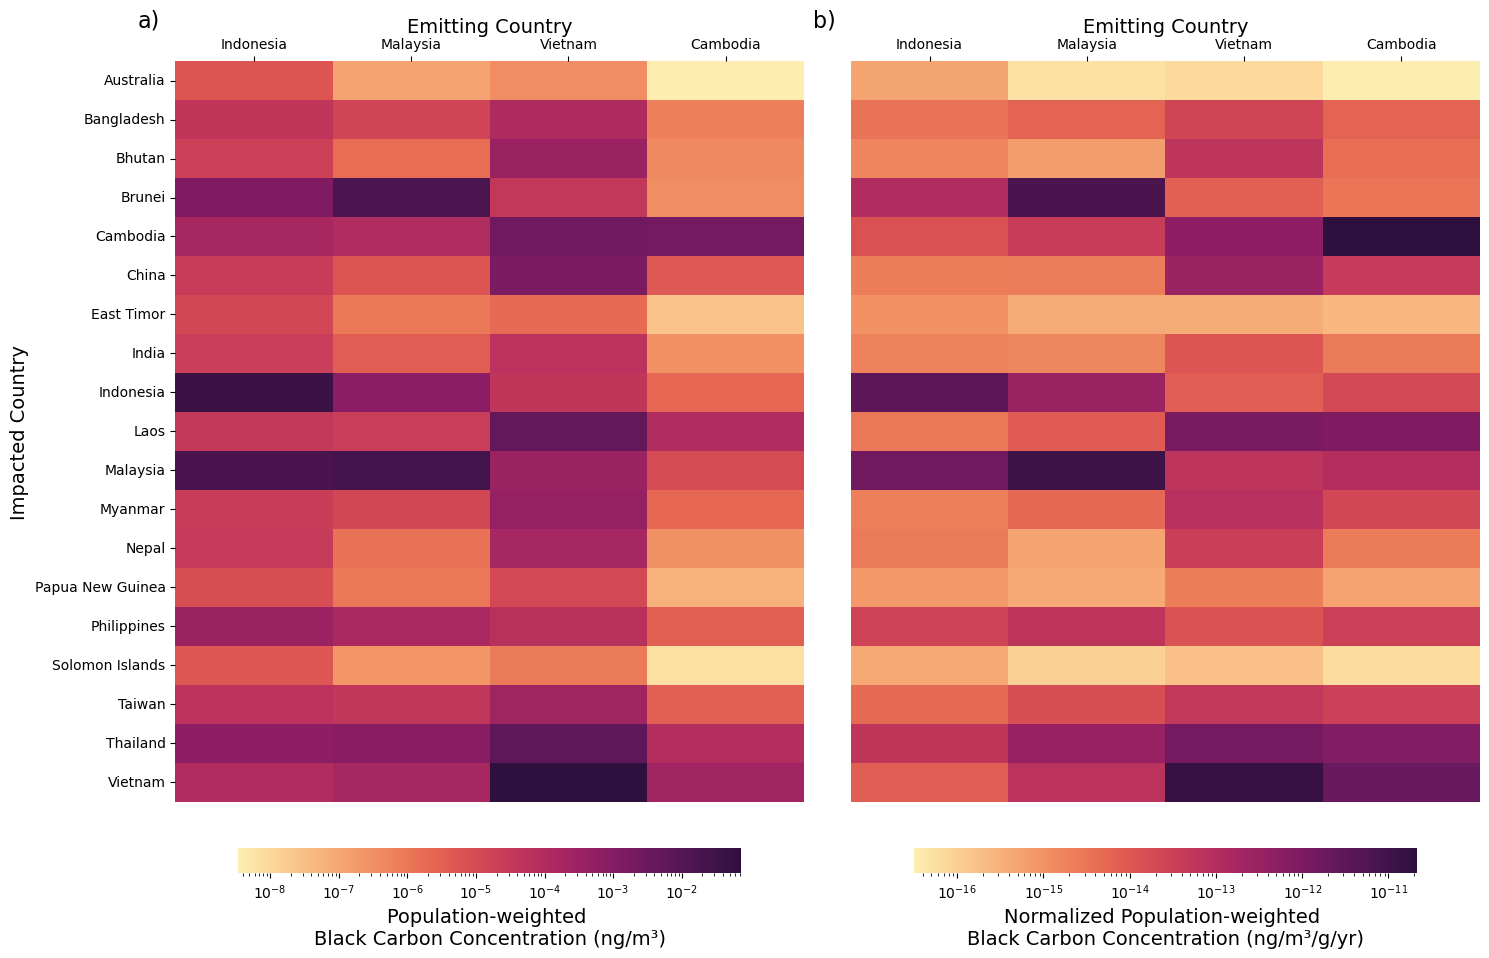

In [ ]:
for year in [2030, 2040, 2050]:
    variable = 'BC_pop_weight_mean_conc'
    # Get regular matrix data
    matrix_regular = plotting_utils.prep_matrix_from_scenario_ds(scenario_ds, year, variable, normalized=False)

    # Get normalized matrix data
    matrix_normalized = plotting_utils.prep_matrix_from_scenario_ds(scenario_ds, year, variable, normalized=True)

    variable='BC_pop_weight_mean_conc' 
                                                
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,10])


    # Plot regular data on left subplot
    plotting_utils.plot_single_matrix(matrix_regular, ax1, variable, title_suffix = 'Regular')

    # Plot normalized data on right subplot  
    plotting_utils.plot_single_matrix(matrix_normalized, ax2, variable, title_suffix='Normalized by Emissions')

    # Labels and title
    ax1.set_xlabel('Emitting Country', fontsize=14)
    ax2.set_xlabel('Emitting Country', fontsize=14)
    ax1.set_ylabel('Impacted Country', fontsize=14)
    ax2.set_yticks([])    


    # Add subplot labels using a loop
    axes = [ax1, ax2]
    labels = ['a)', 'b)']
    
    for ax, label in zip(axes, labels):
        ax.text(-0.06, 1.07, label, transform=ax.transAxes, fontsize=16, 
                 verticalalignment='top')

    plt.tight_layout()
    plt.savefig(f'../figures/paper/matrix/BC_concentration_matrix_normalized_regular_{year}.png', dpi=300)
    plt.close()


In [32]:
for country in ['MALAYSIA','VIETNAM','CAMBODIA','INDONESIA']:
        print(country, normalized_data[country][2040].sort_values('BC_surface_mean_conc', ascending = False)['BC_surface_mean_conc'][:9])

MALAYSIA country_impacted
Malaysia       7.037847e-12
Brunei         7.029936e-12
Indonesia      2.778295e-13
Thailand       2.501160e-13
Philippines    6.528741e-14
Vietnam        4.196546e-14
Cambodia       3.016864e-14
Cambodia       3.016864e-14
Taiwan         1.583600e-14
Name: BC_surface_mean_conc, dtype: float64
VIETNAM country_impacted
Vietnam     8.857752e-12
Thailand    1.239711e-12
Laos        1.086538e-12
Cambodia    3.769894e-13
Cambodia    3.769894e-13
China       2.354575e-13
China       2.354575e-13
China       2.354575e-13
Myanmar     9.208639e-14
Name: BC_surface_mean_conc, dtype: float64
CAMBODIA country_impacted
Cambodia       1.125083e-11
Cambodia       1.125083e-11
Vietnam        1.392968e-12
Thailand       6.919967e-13
Laos           6.740253e-13
Malaysia       4.910456e-14
Myanmar        3.505169e-14
Philippines    3.172465e-14
Taiwan         3.000386e-14
Name: BC_surface_mean_conc, dtype: float64
INDONESIA country_impacted
Indonesia      1.963685e-12
Malaysia  

In [70]:
for country in ['MALAYSIA','VIETNAM','CAMBODIA','INDONESIA']:
        print(country, regular_data[country][2040].sort_values('BC_surface_mean_conc', ascending = False)['BC_surface_mean_conc'][:9])

MALAYSIA country_impacted
Malaysia       0.014721
Brunei         0.014705
Indonesia      0.000581
Thailand       0.000523
Philippines    0.000137
Vietnam        0.000088
Cambodia       0.000063
Taiwan         0.000033
Laos           0.000019
Name: BC_surface_mean_conc, dtype: float64
VIETNAM country_impacted
Vietnam     0.035004
Thailand    0.004899
Laos        0.004294
Cambodia    0.001490
China       0.000930
China       0.000930
China       0.000930
Myanmar     0.000364
Bhutan      0.000264
Name: BC_surface_mean_conc, dtype: float64
CAMBODIA country_impacted
Cambodia       0.000957
Vietnam        0.000119
Thailand       0.000059
Laos           0.000057
Malaysia       0.000004
Myanmar        0.000003
Philippines    0.000003
Taiwan         0.000003
Indonesia      0.000002
Name: BC_surface_mean_conc, dtype: float64
INDONESIA country_impacted
Indonesia      0.018697
Malaysia       0.006359
Brunei         0.001011
Thailand       0.000525
Philippines    0.000292
Cambodia       0.000100
Vi

In [71]:
for country in ['MALAYSIA','VIETNAM','CAMBODIA','INDONESIA']:
        print(country, regular_data[country][2040].loc['China']['BC_surface_mean_conc'])

MALAYSIA country_impacted
China    0.000003
China    0.000003
China    0.000003
Name: BC_surface_mean_conc, dtype: float64
VIETNAM country_impacted
China    0.00093
China    0.00093
China    0.00093
Name: BC_surface_mean_conc, dtype: float64
CAMBODIA country_impacted
China    0.000002
China    0.000002
China    0.000002
Name: BC_surface_mean_conc, dtype: float64
INDONESIA country_impacted
China    0.00001
China    0.00001
China    0.00001
Name: BC_surface_mean_conc, dtype: float64


In [72]:
for country in ['MALAYSIA','VIETNAM','CAMBODIA','INDONESIA']:
        print(country, normalized_data[country][2040].loc['China']['BC_surface_mean_conc'])

MALAYSIA country_impacted
China    1.197423e-15
China    1.197423e-15
China    1.197423e-15
Name: BC_surface_mean_conc, dtype: float64
VIETNAM country_impacted
China    2.354575e-13
China    2.354575e-13
China    2.354575e-13
Name: BC_surface_mean_conc, dtype: float64
CAMBODIA country_impacted
China    2.268566e-14
China    2.268566e-14
China    2.268566e-14
Name: BC_surface_mean_conc, dtype: float64
INDONESIA country_impacted
China    1.026767e-15
China    1.026767e-15
China    1.026767e-15
Name: BC_surface_mean_conc, dtype: float64


## Timeline Trajectories

In [33]:
closure_yr_dict = {'MALAYSIA': 2045, 'CAMBODIA': 2050, 'INDONESIA': 2040, 'VIETNAM': 2050}
rates = {
        'INDONESIA': [9.0, 18.0, 27.0],    # Indonesia: 2-6 plants/year 
        'MALAYSIA': [0.5, 1.0, 2.0],           # Malaysia: 1-2 plants/year
        'VIETNAM': [1.0, 3.0, 5.0]       # Vietnam: 1-5 plants/year
    }

In [34]:

fig, axs, country_data = plotting_utils.compare_multi_country_strategies_and_rates(single_year_ds, countries=[ 'INDONESIA', 'MALAYSIA', 'VIETNAM'],
                                              rates=rates, 
                                              force_closure_by=closure_yr_dict,
                                              strategies=['Year_of_Commission', 'MW', 'EMISFACTOR.CO2'],
                                              impact_var='BC_pop_weight_mean_conc',
                                              impacted_country=list(scenario_ds['country_impacted'].values),
                                              figsize=(20, 12))
plt.savefig(f'../figures/paper/timeline_plots/Malaysia_Indonesia_Vietnam_strategies_comparison.png', dpi=300, bbox_inches='tight')  
plt.close()

[9.0, 18.0, 27.0, 0.5, 1.0, 2.0, 1.0, 3.0, 5.0]


In [35]:
country_data['INDONESIA']['Year_of_Commission'][9.0]

{'years': array([2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
        2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
        2047, 2048, 2049, 2050]),
 'co2_emissions': array([0.29941326, 0.28331105, 0.27378692, 0.26533512, 0.25123763,
        0.2361627 , 0.22143994, 0.20582217, 0.20232777, 0.19950794,
        0.1953879 , 0.19255855, 0.17541145, 0.16376528, 0.14266839,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 'cumulative_co2': array([0.29941326, 0.58272431, 0.85651123, 1.12184634, 1.37308397,
        1.60924667, 1.83068662, 2.03650878, 2.23883655, 2.43834449,
        2.63373239, 2.82629094, 3.00170239, 3.16546767, 3.30813606,
        3.30813606, 3.30813606, 3.30813606, 3.30813606, 3.30813606,
        3.30813606, 3.30813606, 3.30813606, 3.30813606, 3.30813606,
        3.30813606]),
 'bc_concentration': array([0.00162532, 0.00154387

In [36]:
country_data['INDONESIA']['MW'][27.0]

{'years': array([2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
        2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
        2047, 2048, 2049, 2050]),
 'co2_emissions': array([2.99413258e-01, 1.70272164e-01, 8.10688145e-02, 4.73863735e-02,
        3.13664654e-02, 1.86422995e-02, 1.21009240e-02, 7.12219484e-03,
        4.21955124e-03, 2.59066553e-03, 4.33598339e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 'cumulative_co2': array([0.29941326, 0.46968542, 0.55075424, 0.59814061, 0.62950707,
        0.64814937, 0.6602503 , 0.66737249, 0.67159204, 0.67418271,
        0.67422607, 0.67422607, 0.67422607, 0.67422607, 0.67422607,
        0.67422607, 0.67422607, 0.67422607, 0.67422607, 0.67422607,
        0.67422607, 0.674226

#### Print values for text

In [69]:
country = 'VIETNAM'
method = 'EMISFACTOR.CO2'
timeline = 5
variable = 'cumulative_co2'
yr = 2050
country_data[country][method][timeline][variable][yr-2025]

NameError: name 'country_data' is not defined

In [ ]:
country_data[country][method][timeline].keys()

In [ ]:
method = 'MW'
timeline = 3
country_data[country][method][timeline][variable][yr-2025]

In [ ]:
country_data[country].keys()

In [37]:
for country in ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM']:
    #for impacted_country in ['Thailand', 'Vietnam', 'Laos', 'Cambodia']:
    fig, axs, co2_data = plotting_utils.compare_individual_strategies_and_rates(
        single_year_ds,
        rates=[0.5, 2.0, 4.0, 6.0, 8.0, 10.0, 14.0, 18.0, 22.0, 26.0, 30.0],
        force_closure_by=closure_yr_dict[country],
        strategies=['Year_of_Commission', 'MW', 'EMISFACTOR.CO2'],
        impact_var='BC_pop_weight_mean_conc',   
        impacted_country= list(scenario_ds['country_impacted'].values),
        country = country
    )

    plt.savefig(f'../figures/paper/timeline_plots/{country}_combined_strategies_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045]
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045]
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045]
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045]
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045]
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045]
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045]
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045]
[2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038
 2039 2040 2041 2042 2043 2044 2045]
[2025 2026 2027 2028 2029 20

## Sankey Diagram

In [53]:
for yy in [10, 20, 50, 100]:     
    fig, data = plotting_utils.create_sankey_from_map_data(regular_data, norm_data=normalized_data, temp_data=temp_data[yy], temp_norm_data=normalized_temp_data[yy],
                                year=2040, location='all', 
                                variable='BC_pop_weight_mean_conc', temp_variable=f'temperature_impact_aamaas_{yy}',
                                top_n=20, allow_loops=False)
    fig.write_image(f"../figures/paper/sankey/sankey_diagram_2040_{yy}_timescale.png", width=1100, height=800, scale = 2) 
    
    #fig.show()


Combined top receptors: {'Bangladesh', 'Bhutan', 'Thailand', 'Brunei', 'Vietnam', 'India', 'Nepal', 'Laos', 'Malaysia', 'East Timor', 'Indonesia', 'Solomon Islands', 'Myanmar', 'Papua New Guinea', 'Taiwan', 'Philippines', 'Cambodia', 'China', 'Australia'}
Australia
Bangladesh
Bhutan
Brunei
Cambodia
China
East Timor
India
Indonesia
Laos
Malaysia
Myanmar
Nepal
Papua New Guinea
Philippines
Solomon Islands
Taiwan
Thailand
Vietnam
Australia
Bangladesh
Bhutan
Brunei
Cambodia
China
East Timor
India
Indonesia
Laos
Malaysia
Myanmar
Nepal
Papua New Guinea
Philippines
Solomon Islands
Taiwan
Thailand
Vietnam
Australia
Bangladesh
Bhutan
Brunei
Cambodia
China
East Timor
India
Indonesia
Laos
Malaysia
Myanmar
Nepal
Papua New Guinea
Philippines
Solomon Islands
Taiwan
Thailand
Vietnam
Australia
Bangladesh
Bhutan
Brunei
Cambodia
China
East Timor
India
Indonesia
Laos
Malaysia
Myanmar
Nepal
Papua New Guinea
Philippines
Solomon Islands
Taiwan
Thailand
Vietnam
Combined top receptors: {'Bangladesh', 'Bhutan',

In [ ]:
for top_n in [10, 20]:
    sankey_data = {}
    for yy in ['drf_toa', 'snowrf_toa', 'sum_rf_toa', 'dt_drf',
        'dt_snowrf', 'dt_sum']:     
        fig, sankey_data[yy] = plotting_utils.create_multi_source_sankey(
                                                regular_data, 
                                                norm_data=normalized_data, 
                                                temp_data=temp_data[yy], 
                                                temp_norm_data=normalized_temp_data[yy],
                                                year=2040, 
                                                variable='BC_pop_weight_mean_conc', 
                                                temp_variable=f'{yy}',
                                                top_n=top_n)
        fig.write_image(f"../figures/paper/sankey/sankey_diagram_2040_{yy}_top{top_n}.png", width=1100, height=800, scale = 2)

        #fig.show()


In [28]:
(regular_data['INDONESIA'][2040]['BC_pop_weight_mean_conc'].sort_values(ascending = False)/
    regular_data['INDONESIA'][2040]['BC_pop_weight_mean_conc']['Indonesia'])

country_impacted
Indonesia           1.000000
Malaysia            0.477325
Brunei              0.032190
Thailand            0.017002
Philippines         0.008120
Cambodia            0.004193
Vietnam             0.002444
Taiwan              0.001414
Bangladesh          0.001039
Laos                0.000892
Nepal               0.000789
China               0.000676
China               0.000676
China               0.000676
Myanmar             0.000649
India               0.000594
Bhutan              0.000522
East Timor          0.000328
Papua New Guinea    0.000239
Australia           0.000152
Australia           0.000152
Australia           0.000152
Australia           0.000152
Australia           0.000152
Australia           0.000152
Solomon Islands     0.000133
Name: BC_pop_weight_mean_conc, dtype: float64

In [97]:
for c in temp_data['dt_sum'].keys():
    print(c, temp_data['dt_sum'][c][np.int64(2040)]['dt_sum'].mean()*1e6)

MALAYSIA 20.42808936
CAMBODIA 0.828161434
INDONESIA 76.11196324699996
VIETNAM 33.823787652
all 131.19200169300007


## Temperature, Emissions, Concentration over Time

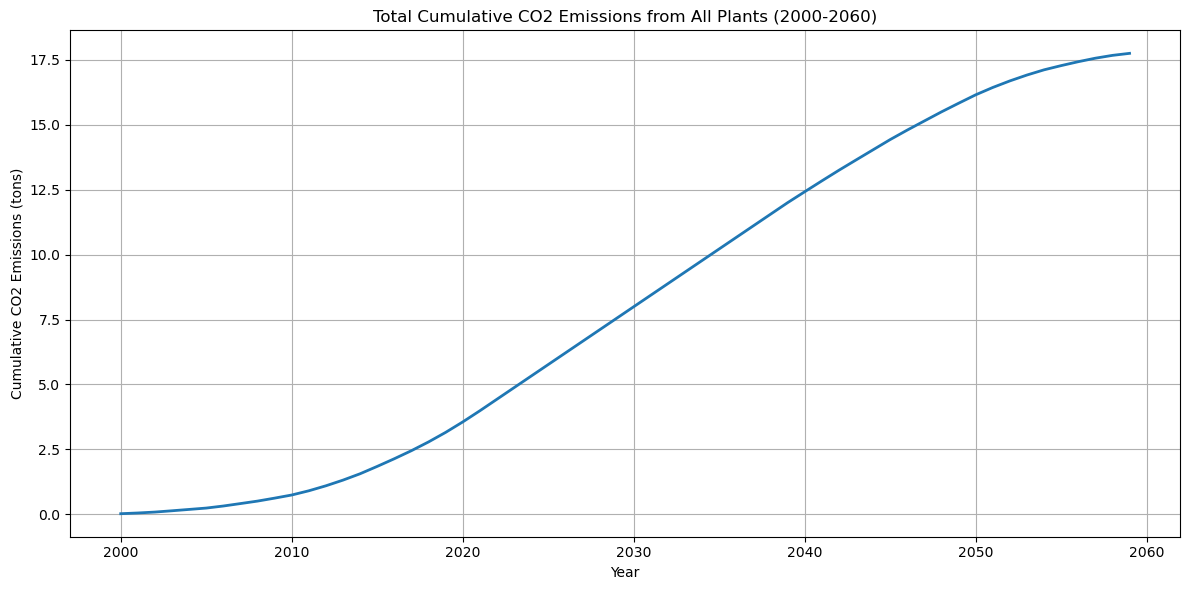

In [9]:
# Set up time array from 2000 to 2060
start_year = 2000
end_year = 2060
years = end_year - start_year
length_simulation = years * 365
time_array = np.arange(0, length_simulation)

# Calculate total CO2 emissions over time
total_emissions = np.zeros(length_simulation)
for unique_id in CGP_df['unique_ID'].values:
    # Get plant data
    plant_data = CGP_df.loc[CGP_df['unique_ID'] == unique_id]
    
    # Calculate annual CO2 emissions (in gigatons)
    annual_co2 = plant_data['co2_emissions']/1e9
    
    # Convert to daily emissions
    daily_co2 = annual_co2 / 365  # tons per day
    
    # Add to total emissions
    yr_offset = (plant_data['Year_of_Commission'].iloc[0] - start_year)
    if yr_offset >= 0:  # Only include plants commissioned after 2000
        test_array = np.where((time_array <= (yr_offset + 40)*365) & (time_array >= yr_offset * 365), True, False)
        total_emissions += test_array * daily_co2.values[0]

# Convert daily emissions to yearly and take cumulative sum
yearly_emissions = total_emissions.reshape(years, 365).sum(axis=1)
cumulative_emissions = np.cumsum(yearly_emissions)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(np.arange(start_year, end_year), cumulative_emissions, linewidth=2)

plt.xlabel('Year')
plt.ylabel('Cumulative CO2 Emissions (tons)')
plt.title('Total Cumulative CO2 Emissions from All Plants (2000-2060)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
TCR = RTCRE.weighted(area_weights).mean().values

In [11]:
TCR

array(1.80972773)

In [12]:
color_palette = {
    0: '#005F73',   # Dark Teal Blue
    1: '#0F8B8D',   # Dark Teal
    2: '#3CAEA3',   # Aqua
    3: '#68C3B1',   # Mint
    4: '#7CBB9F',   # Light Sage
    5: '#A8C256',   # Yellow-Green
    6: '#C9BC3F',   # Olive Yellow
    7: '#D85E0D',   # Dark Orange
    8: '#E66F20',   # Rust Orange
    9: '#E07C10',   # Burnt Orange
    10: '#FF7D00',  # Vivid Orange
    11: '#FF9F1C',  # Amber
    12: '#FFBC42',  # Deep Yellow
    13: '#FFDA44',  # Mustard Yellow
    14: '#FFF07C'   # Pale Yellow
}
# Breakdown by parent country
emissions, temp = plotting_utils.plot_emissions_and_temperature(
    CGP_df, 
    breakdown_by='PAR.COUNTRY', 
    colors_in=color_palette,
    tcr = TCR
)


# Get all axes from the current figure
axes = plt.gcf().get_axes()

# Add a title to the first legend (emissions plot, upper left subplot)
legend = axes[0].get_legend()
if legend:
    legend.set_title('Parent Country')

plt.tight_layout()
plt.savefig('../figures/paper/temperature_emissions/CO2_breakdown_by_parent_country.png', dpi=300, bbox_inches='tight')
plt.close()

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:1913: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_co2 = float(plant_data['co2_emissions']) / 1e9  # Convert to GtCO2 and ensure scalar


/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2588: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_co2 = float(plant_data['co2_emissions']) / 1e9  # Convert to GtCO2
/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2589: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_bc = float(plant_data['BC_(g/yr)'])  # BC emissions in g/yr
/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2590: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_dt_drf = float(plant_data['dt_drf'])
/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2591: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError


Values at 2060:
Cumulative CO2 Emissions: 1.77e+01 tons
CO2 Temperature Response: 0.032123 K
Cumulative BC Emissions: 1.90e+10 g
Total BC Temperature Response: 0.000160 K
Total snow BC response: 0.00000181 K
Total DRF BC response: 0.000158 K
Total Temperature Response: 0.032283 K
Min Temperature Response: 0.021886 K
Max Temperature Response: 0.042740 K
Lifetime min Temperature Response: 0.028094 K
Lifetime max Temperature Response: 0.035004 K



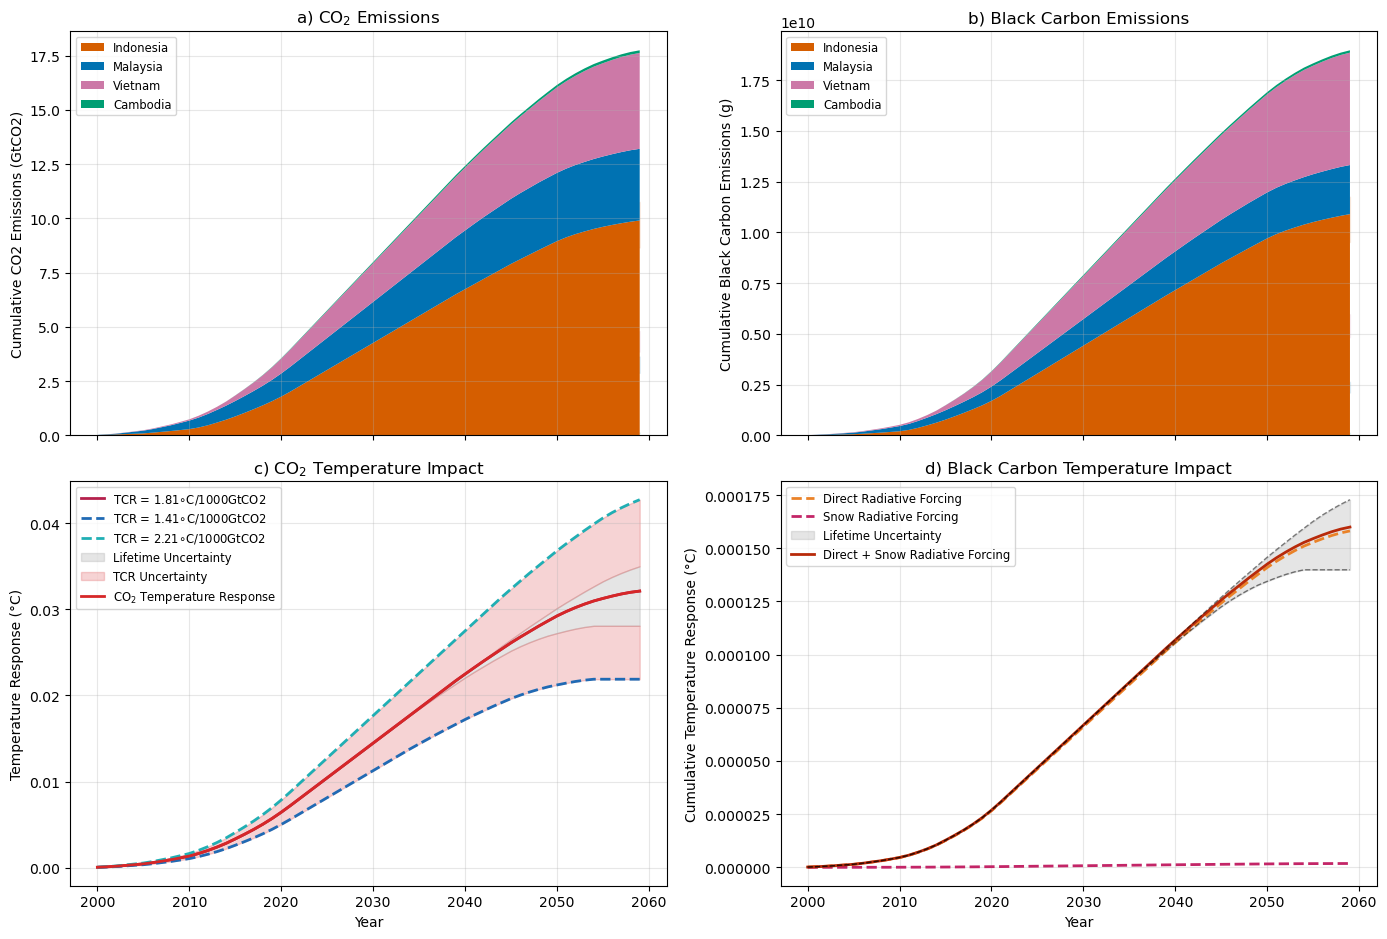

In [23]:
cumulative_emissions, co2_temp_response, cumulative_bc_emissions, cumulative_dt_drf, cumulative_dt_snowrf, total_bc_temp_response, total_temp_response, max_temp_response, min_temp_response, min_bc_temp_response, max_bc_temp_response, min_combined_tcr, max_combined_tcr = plotting_utils.plot_emissions_and_temperature_with_bc(
    CGP_df, 
    breakdown_by='COUNTRY',
    tcr = TCR
)


# Print 2060 values (index 60 for year 2060)
print("\n" + "="*80)
print("Values at 2060:")
print("="*80)
print(f"Cumulative CO2 Emissions: {cumulative_emissions[59]:.2e} tons")
print(f"CO2 Temperature Response: {co2_temp_response[59]:.6f} K")
print(f"Cumulative BC Emissions: {cumulative_bc_emissions[59]:.2e} g")
print(f"Total BC Temperature Response: {total_bc_temp_response[59]:.6f} K")
print(f"Total snow BC response: {cumulative_dt_snowrf[59]:.8f} K")
print(f"Total DRF BC response: {cumulative_dt_drf[59]:.6f} K")
print(f"Total Temperature Response: {total_temp_response[59]:.6f} K")
print(f"Min Temperature Response: {min_combined_tcr[59]:.6f} K")
print(f"Max Temperature Response: {max_combined_tcr[59]:.6f} K")
print(f"Lifetime min Temperature Response: {min_temp_response[59]:.6f} K")
print(f"Lifetime max Temperature Response: {max_temp_response[59]:.6f} K")
print("="*80 + "\n")

plt.savefig('../figures/paper/temperature_emissions/BC_raisanen_breakdown_by_country.png', dpi=300, bbox_inches='tight')
#plt.close()

In [19]:
min_temp_response

array([4.39571676e-05, 9.47795565e-05, 1.58478479e-04, 2.48324906e-04,
       3.42241123e-04, 4.36636526e-04, 5.79806325e-04, 7.49995022e-04,
       9.22536337e-04, 1.12874716e-03, 1.34694603e-03, 1.64059518e-03,
       1.98852721e-03, 2.38480679e-03, 2.82796717e-03, 3.34053997e-03,
       3.87397536e-03, 4.43530688e-03, 5.04446911e-03, 5.70949488e-03,
       6.43758762e-03, 7.21387466e-03, 8.01962647e-03, 8.82537829e-03,
       9.63113010e-03, 1.04368819e-02, 1.12426337e-02, 1.20483855e-02,
       1.28541374e-02, 1.36598892e-02, 1.44656410e-02, 1.52713928e-02,
       1.60771446e-02, 1.68828964e-02, 1.76886482e-02, 1.84504429e-02,
       1.92053723e-02, 1.99474252e-02, 2.06633306e-02, 2.13751662e-02,
       2.20865226e-02, 2.27491046e-02, 2.33846677e-02, 2.40178782e-02,
       2.46174192e-02, 2.52049722e-02, 2.57170748e-02, 2.61748946e-02,
       2.65843669e-02, 2.69469583e-02, 2.72401373e-02, 2.75124537e-02,
       2.77568740e-02, 2.79534636e-02, 2.80941897e-02, 2.80941897e-02,
      

In [35]:
# With breakdown by country
emissions, co2_temp, bc_emissions, bc_temp_global20, bc_temp_other, total_temp = plotting_utils.plot_emissions_and_temperature_with_bc_artp(CGP_df, breakdown_by='COUNTRY')
plt.savefig('../figures/paper/temperature_emissions/BC_artp_breakdown_by_country.png', dpi=300, bbox_inches='tight')
plt.close()

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:1779: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:1780: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:1783: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:1784: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:1785: FutureWarning:

Calling float on a single element Series is depre

## Bar plots by country/top groups

In [26]:
gdf_benefits = plotting_utils.prepare_plant_benefits_data(
    single_year_ds, CGP_df, impact_var='BC_pop_weight_mean_conc'
)


In [27]:
top_bc_per_mw, top_temp_per_mw, top_bc_lifetime, top_temp_lifetime, all_top_indices, appearances = plotting_utils.get_topn(gdf_benefits, 10)

In [99]:
# Calculate marginal benefit for top 30 plants for each metric
n_values = np.arange(1, 353)

print("Marginal Benefit per Plant:\n")
print("=" * 80)

for output in ['temp_benefit_per_mw', 'bc_benefit_per_mw', 'total_temp_benefit_lifetime', 'total_bc_benefit_lifetime']:
    # Calculate cumulative benefit percentage
    cumulative_pct = []
    for n in n_values:
        pct = (gdf_benefits.sort_values(output, ascending=False)[:n][output].sum() / 
               gdf_benefits[output].sum()) * 100
        cumulative_pct.append(pct)
    
    cumulative_pct = np.array(cumulative_pct)
    
    # Calculate derivative (marginal benefit per plant)
    marginal_benefit = np.gradient(cumulative_pct, n_values)
    
    # Get marginal benefit at n=1 (first plant)
    marginal_benefit_at_1 = marginal_benefit[0]
    
    # Get marginal benefit at n=30
    marginal_benefit_at_30 = marginal_benefit[29]  # Index 29 corresponds to n=30
    
    # Get cumulative benefit at n=30
    cumulative_benefit_at_30 = cumulative_pct[29]
    
    print(f"\n{label_names[output]}:")
    print(f"  Marginal benefit at plant 1: {marginal_benefit_at_1:.4f}% per plant")
    print(f"  Marginal benefit at plant 30: {marginal_benefit_at_30:.4f}% per plant")
    print(f"  Cumulative benefit (top 30): {cumulative_benefit_at_30:.2f}%")
    print(f"  Average benefit per plant (1/{total_plants}): {100/total_plants:.4f}%")
    

print("\n" + "=" * 80)

Marginal Benefit per Plant:


Temperature Decrease per MW:
  Marginal benefit at plant 1: 0.9374% per plant
  Marginal benefit at plant 30: 0.3519% per plant
  Cumulative benefit (top 30): 18.48%
  Average benefit per plant (1/353): 0.2833%

Black Carbon Concentration Decrease per MW:
  Marginal benefit at plant 1: 0.8077% per plant
  Marginal benefit at plant 30: 0.5915% per plant
  Cumulative benefit (top 30): 19.95%
  Average benefit per plant (1/353): 0.2833%

Total Temperature Decrease over Lifetime:
  Marginal benefit at plant 1: 1.6243% per plant
  Marginal benefit at plant 30: 0.8837% per plant
  Cumulative benefit (top 30): 36.57%
  Average benefit per plant (1/353): 0.2833%

Total Black Carbon Concentration Decrease over Lifetime:
  Marginal benefit at plant 1: 3.0089% per plant
  Marginal benefit at plant 30: 1.1992% per plant
  Cumulative benefit (top 30): 46.53%
  Average benefit per plant (1/353): 0.2833%



In [49]:
for n in [5,10, 30]:
    for output in ['temp_benefit_per_mw', 'bc_benefit_per_mw', 'total_bc_benefit_lifetime', 'total_temp_benefit_lifetime']: 
        print(f'top {n} in each {output}', np.round((gdf_benefits.sort_values(output, ascending = False)[:n][output].sum()/gdf_benefits[output].sum())*100, 3), '%')

top 5 in each temp_benefit_per_mw 4.54 %
top 5 in each bc_benefit_per_mw 4.438 %
top 5 in each total_bc_benefit_lifetime 11.487 %
top 5 in each total_temp_benefit_lifetime 8.1 %
top 10 in each temp_benefit_per_mw 8.983 %
top 10 in each bc_benefit_per_mw 7.741 %
top 10 in each total_bc_benefit_lifetime 19.668 %
top 10 in each total_temp_benefit_lifetime 15.766 %
top 30 in each temp_benefit_per_mw 18.479 %
top 30 in each bc_benefit_per_mw 19.947 %
top 30 in each total_bc_benefit_lifetime 46.533 %
top 30 in each total_temp_benefit_lifetime 36.568 %


temp_benefit_per_mw: crosses average benefit at n=126 plants
bc_benefit_per_mw: crosses average benefit at n=104 plants
total_temp_benefit_lifetime: crosses average benefit at n=111 plants
total_bc_benefit_lifetime: crosses average benefit at n=90 plants


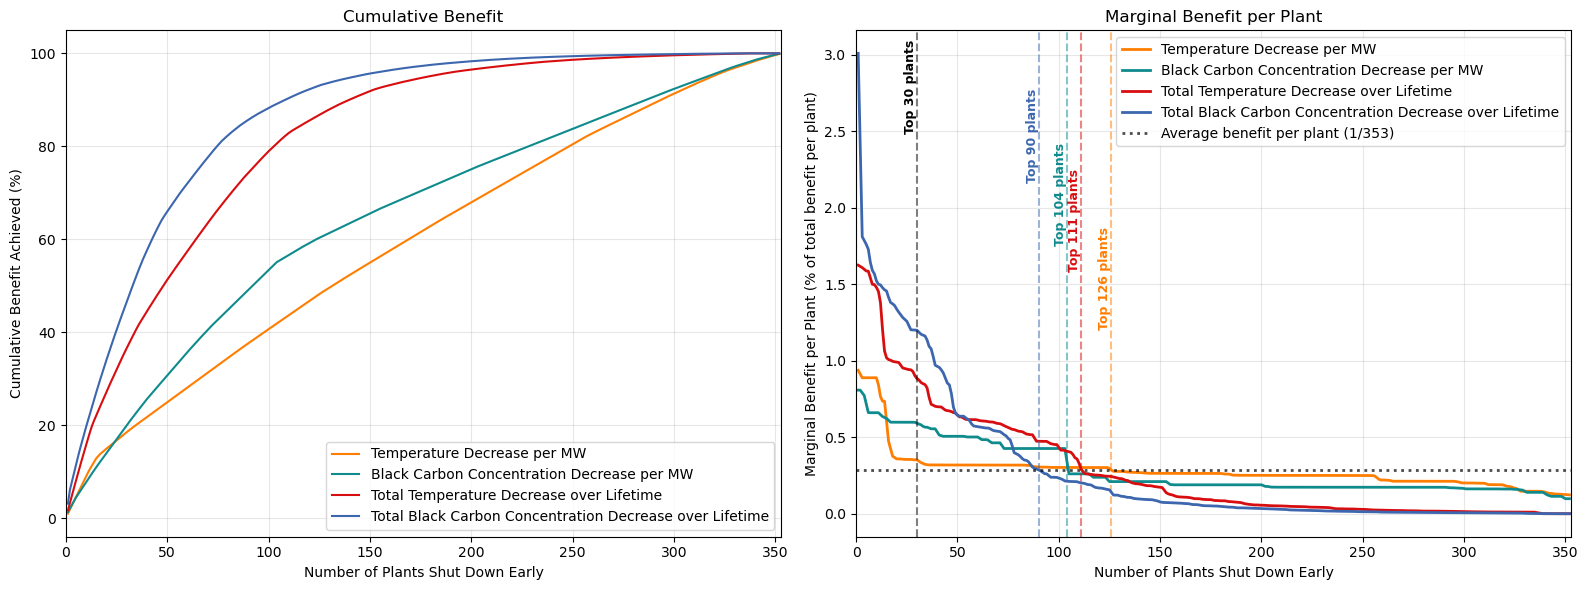

In [ ]:
color_palette = {
    'temp_benefit_per_mw': '#FF7D00',  # Vivid Orange
    'bc_benefit_per_mw': '#0F8B8D',    # Dark Teal
    'total_bc_benefit_lifetime': "#3C66AE",  # Aqua
    'total_temp_benefit_lifetime': "#D80D10"  # Dark Orange
}
label_names = {
    'temp_benefit_per_mw': 'Temperature Decrease per MW',
    'bc_benefit_per_mw': 'Black Carbon Concentration Decrease per MW',
    'total_temp_benefit_lifetime': 'Total Temperature Decrease over Lifetime',
    'total_bc_benefit_lifetime': 'Total Black Carbon Concentration Decrease over Lifetime'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

n_values = np.arange(1, 353)
total_plants = len(gdf_benefits)  
average_benefit = 100 / total_plants  # Average marginal benefit per plant

for output in ['temp_benefit_per_mw', 'bc_benefit_per_mw', 'total_temp_benefit_lifetime', 'total_bc_benefit_lifetime']:
    # Calculate cumulative benefit percentage
    cumulative_pct = []
    for n in n_values:
        pct = (gdf_benefits.sort_values(output, ascending=False)[:n][output].sum() / 
               gdf_benefits[output].sum()) * 100
        cumulative_pct.append(pct)
    
    cumulative_pct = np.array(cumulative_pct)
    
    # Plot cumulative benefit
    ax1.plot(n_values, cumulative_pct, color=color_palette[output], 
             label=label_names[output], markersize=3)
    
    # Calculate derivative (marginal benefit per plant)
    marginal_benefit = np.gradient(cumulative_pct, n_values)
    
    # Plot marginal benefit
    ax2.plot(n_values, marginal_benefit, '-', color=color_palette[output], 
             label=label_names[output], linewidth=2)
    
    # Find where marginal benefit crosses average benefit threshold
    crossover_indices = np.where(np.diff(np.sign(marginal_benefit - average_benefit)))[0]
    
    if len(crossover_indices) > 0:
        # Use the first crossing point (going from above to below)
        for cross_idx in crossover_indices:
            if marginal_benefit[cross_idx] > average_benefit and marginal_benefit[cross_idx + 1] < average_benefit:
                crossover_n = n_values[cross_idx]
                ax2.axvline(crossover_n, color=color_palette[output], linestyle='--', alpha=0.5, linewidth=1.5)
                
                # Add text label along the vertical line
                ax2.text(crossover_n, 5-2.5e-2*cross_idx, f'Top {crossover_n} plants', 
                        rotation=90, verticalalignment='top', horizontalalignment='right',
                        color=color_palette[output], fontsize=9, fontweight='bold')
                
                print(f"{output}: crosses average benefit at n={crossover_n} plants")
                break
  
# Add horizontal line for average benefit in right plot
ax2.axhline(average_benefit, color='black', linestyle=':', linewidth=2, 
            label=f'Average benefit per plant (1/{total_plants})', alpha=0.7)

ax2.axvline(30, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.text(30, ax2.get_ylim()[1] * 0.98, f'Top 30 plants', 
        rotation=90, verticalalignment='top', horizontalalignment='right', color='black', fontsize=9, fontweight='bold')

ax1.set_xlabel('Number of Plants Shut Down Early')
ax1.set_ylabel('Cumulative Benefit Achieved (%)')
ax1.set_title('Cumulative Benefit')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 353)

ax2.set_xlabel('Number of Plants Shut Down Early')
ax2.set_ylabel('Marginal Benefit per Plant (% of total benefit per plant)')
ax2.set_title('Marginal Benefit per Plant')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 353)

plt.tight_layout()
plt.savefig('../figures/paper/plant_benefits/marginal_benefit_per_plant.png', dpi=300, bbox_inches='tight') 

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:4243: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Plant Benefits Summary:
Number of plants: 353
BC benefit per MW - Mean: 6.31e-08, Range: 2.18e-08 - 2.85e-07
Temp benefit per MW - Mean: 1.34e-08, Range: 5.84e-09 - 4.45e-08
Median BC benefit per MW: 4.20e-08
Median Temp benefit per MW: 1.25e-08

Benefit Category Counts:
Above Median (Temp): 103 plants (29.2%)
Above Median (Black Carbon): 103 plants (29.2%)
Below Median (Temperature and Black Carbon): 74 plants (21.0%)
Above Median (Temperature and Black Carbon): 73 plants (20.7%)

MEDIAN VALUES
Lifetime bc benefit median, all plants: 7.382703588078804e-05
Lifetime temp benefit median, all plants: 1.8142205970859997e-05
BC/MW benefit median, all plants: 4.203227518301434e-08
Temp/MW benefit median, all plants: 1.2487318386500004e-08

PLANT TRACKING ANALYSIS

Total unique plants appearing in any top-30 list: 98
Plants appearing in multiple lists (hatched): 20
Plants appearing in only one list (no hatch): 78

Plants by number of top-30 list appearances:

Plants in 3 lists (2 plants - wi

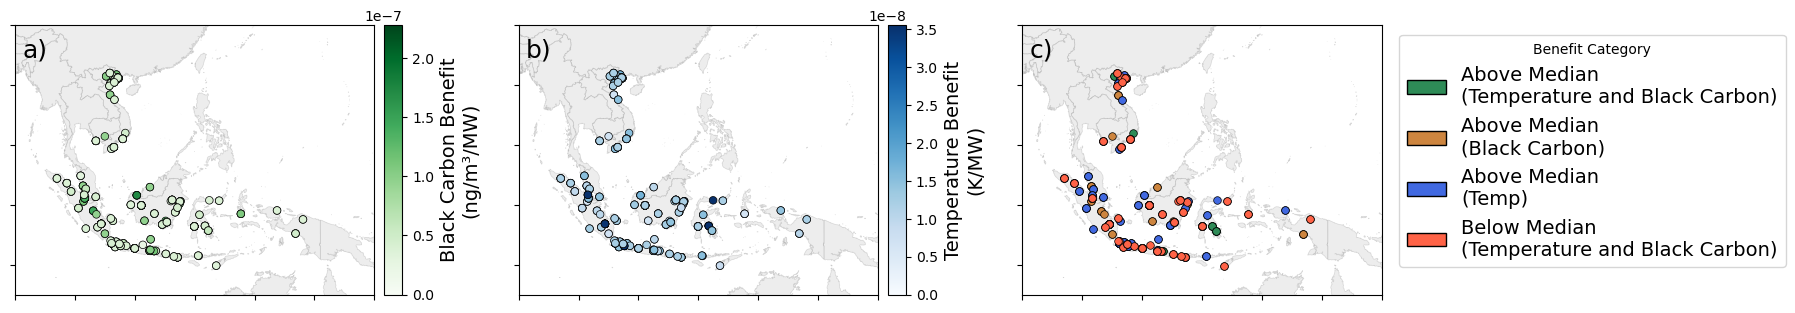

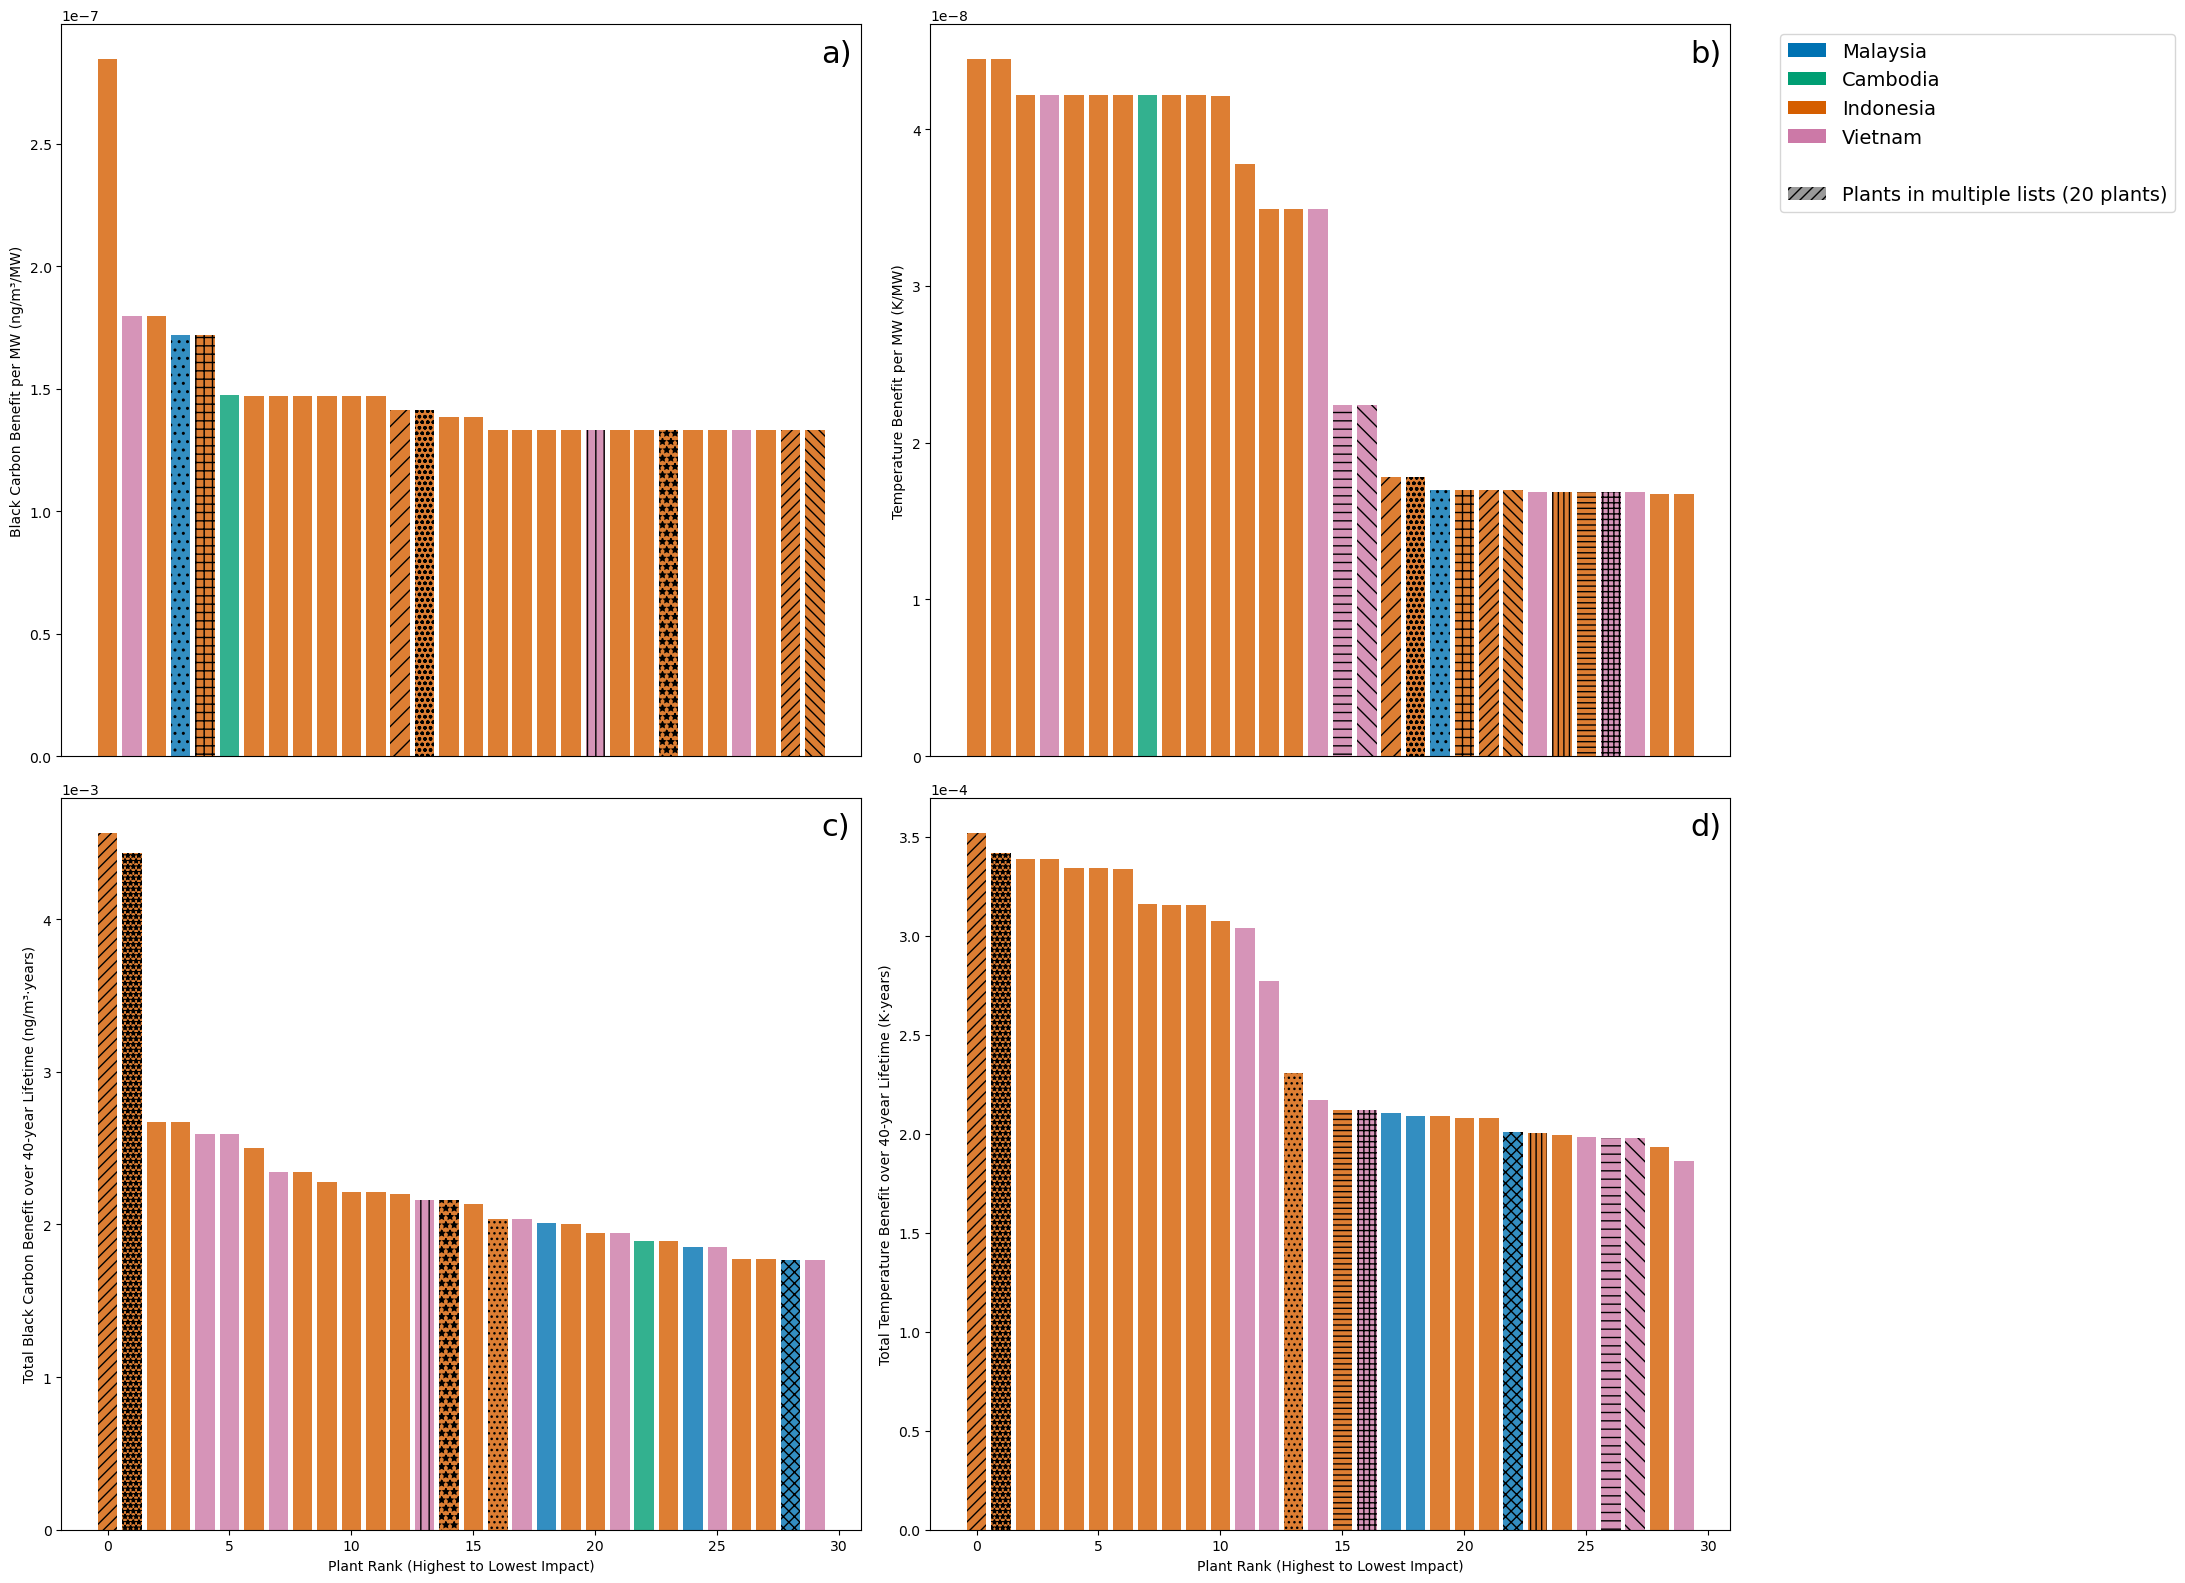

In [30]:
# Prepare all data once - this replaces both previous function calls
gdf_benefits = plotting_utils.prepare_plant_benefits_data(
    single_year_ds, CGP_df, impact_var='BC_pop_weight_mean_conc'
)

# Create the maps
fig_maps = plotting_utils.plot_plant_benefits_maps(gdf_benefits, country_df, figsize=(18, 6))
plt.savefig('../figures/paper/per_capacity/plant_benefits_per_capacity_map.png', dpi=300, bbox_inches='tight')

# Create the bar plots
plotting_utils.plot_plant_benefits_bars(gdf_benefits, n = 30, save_path='../figures/paper/bar/top30_per_mw_plant_benefits.png')


In [38]:
top_bc_per_mw, top_temp_per_mw, top_bc_lifetime, top_temp_lifetime, all_top_indices, appearances = plotting_utils.get_topn(gdf_benefits, n = 30)


In [39]:
def topn_to_csv(topn_df, CGP_df, name):
    topn_df = topn_df.set_index('unique_ID')
    CGP_df[['UNIT','PLANT','COMPANY','PAR.COUNTRY','Year_of_Commission']].loc[topn_df.index].merge(topn_df, left_index=True, right_index=True).to_csv(f'../data_output/supplement/{name}.csv')


In [40]:
for df, name in zip([top_bc_per_mw, top_temp_per_mw, top_bc_lifetime, top_temp_lifetime],  ['top_bc_per_mw', 'top_temp_per_mw', 'top_bc_lifetime', 'top_temp_lifetime']):
    topn_to_csv(df, CGP_df, name)
    print(name)

top_bc_per_mw
top_temp_per_mw
top_bc_lifetime
top_temp_lifetime


In [36]:
# Add this diagnostic code to your notebook to check what's happening:
for metric in ['bc_benefit_per_mw', 'temp_benefit_per_mw', 
               'total_bc_benefit_lifetime', 'total_temp_benefit_lifetime']:
    top_30 = gdf_benefits.nlargest(30, metric)
    print(f"\n{metric}:")
    print(f"  Total plants: {len(top_30)}")
    print(f"  Unique lat/lon combinations: {len(top_30[['latitude', 'longitude']].drop_duplicates())}")
    print(f"  Country distribution:")
    print(top_30['country'].value_counts())
    
    # Check for plants at exact same location
    duplicates = top_30[top_30.duplicated(['latitude', 'longitude'], keep=False)]
    if len(duplicates) > 0:
        print(f"  Plants at same location: {len(duplicates)}")
        print(duplicates[['unique_ID', 'country', 'latitude', 'longitude', metric]])


bc_benefit_per_mw:
  Total plants: 30
  Unique lat/lon combinations: 19
  Country distribution:
country
INDONESIA    25
VIETNAM       3
MALAYSIA      1
CAMBODIA      1
Name: count, dtype: int64
  Plants at same location: 19
     unique_ID    country   latitude   longitude  bc_benefit_per_mw
117        122  INDONESIA  -3.219310  104.407506       2.846653e-07
163        172    VIETNAM  21.171805  107.201274       1.798623e-07
224        233  INDONESIA   2.192352   99.381220       1.798623e-07
91          95  INDONESIA  -6.889190  107.640472       1.719548e-07
62          66  INDONESIA  -3.219310  104.407506       1.469840e-07
63          67  INDONESIA  -1.027470  103.079926       1.469840e-07
64          68  INDONESIA  -1.027470  103.079926       1.469840e-07
65          69  INDONESIA  -1.027470  103.079926       1.469840e-07
269        281  INDONESIA   0.495230  117.530017       1.414603e-07
265        277  INDONESIA   1.049808  101.654843       1.386099e-07
76          80  INDONESIA  


Black Carbon Concentration
Decrease per MW:
  Total plants: 30
  Unique locations: 19
  Value range: 1.33e-07 - 2.85e-07
  Countries represented:
    INDONESIA: 25 plants
    VIETNAM: 3 plants
    MALAYSIA: 1 plants
    CAMBODIA: 1 plants

Temperature
Decrease per MW:
  Total plants: 30
  Unique locations: 22
  Value range: 1.67e-08 - 4.45e-08
  Countries represented:
    INDONESIA: 21 plants
    VIETNAM: 7 plants
    CAMBODIA: 1 plants
    MALAYSIA: 1 plants

Total Black Carbon Concentration
Decrease over Lifetime:
  Total plants: 30
  Unique locations: 25
  Value range: 1.77e-03 - 4.57e-03
  Countries represented:
    INDONESIA: 18 plants
    VIETNAM: 8 plants
    MALAYSIA: 3 plants
    CAMBODIA: 1 plants

Total Temperature
Decrease over Lifetime:
  Total plants: 30
  Unique locations: 25
  Value range: 1.86e-04 - 3.52e-04
  Countries represented:
    INDONESIA: 19 plants
    VIETNAM: 8 plants
    MALAYSIA: 3 plants

Figure saved to: ../figures/talks/top30_plants_benefits_maps.png


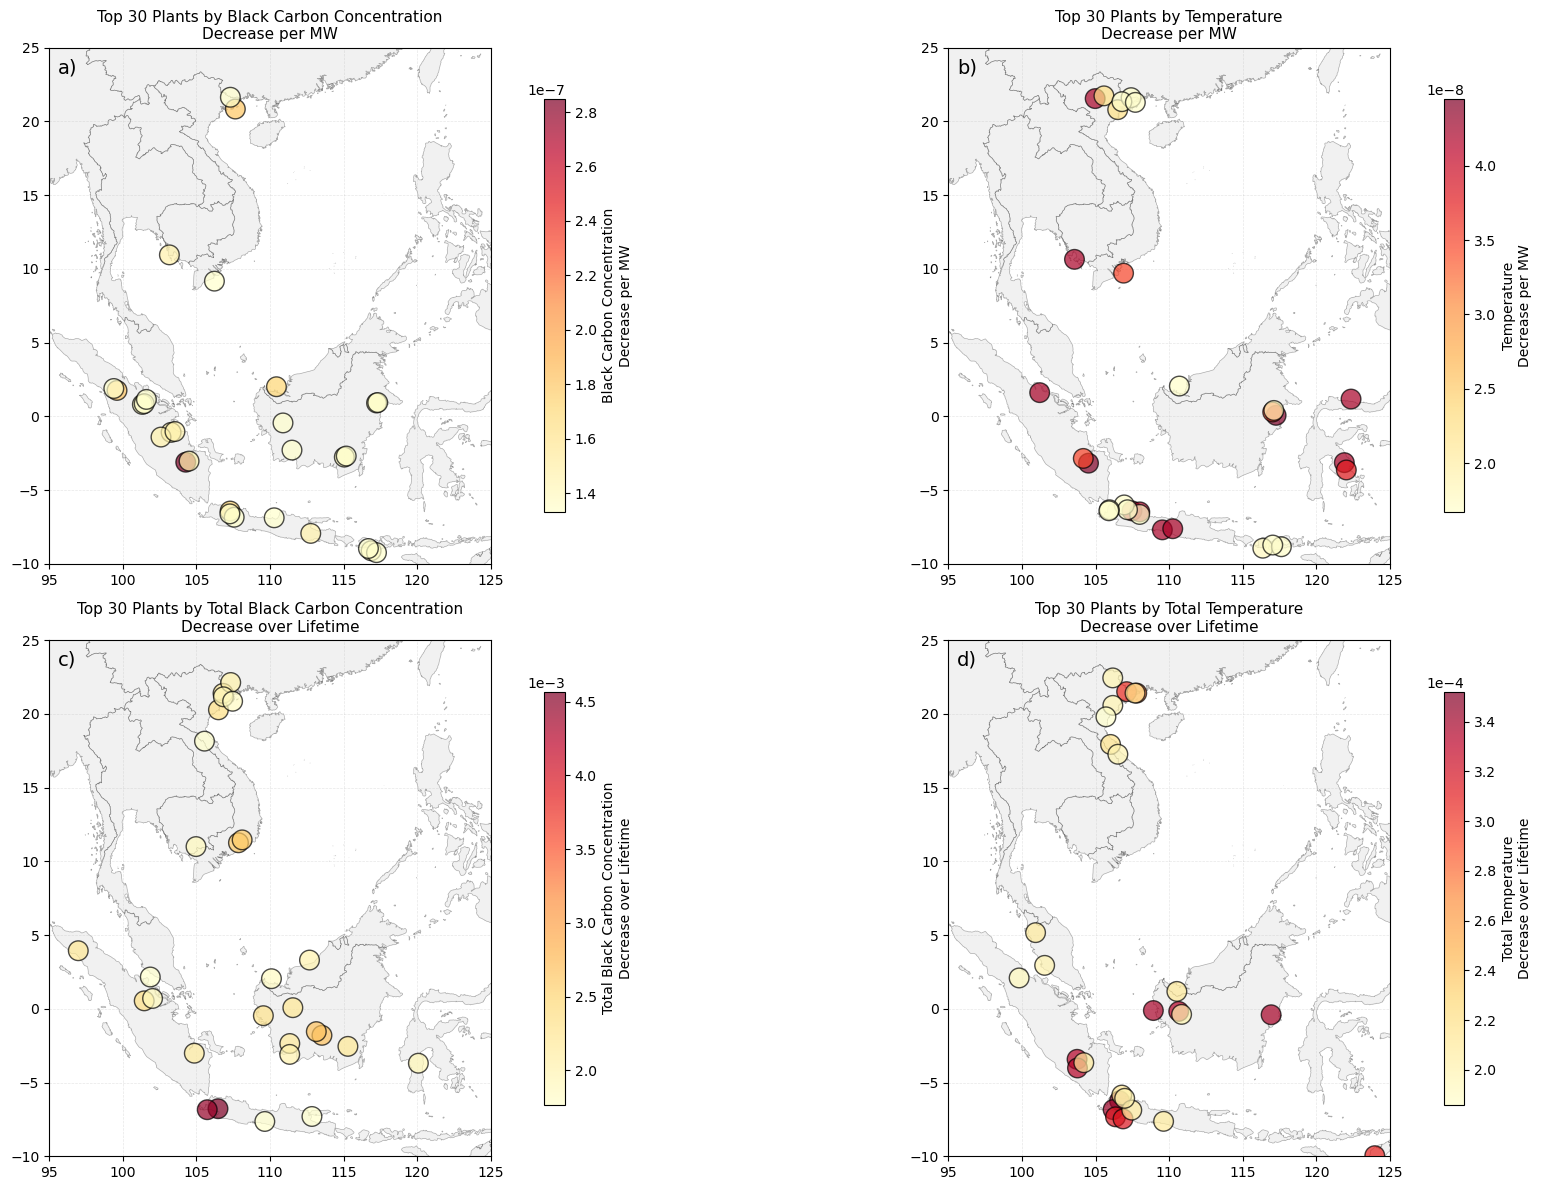

In [39]:
# More jitter (for very clustered points)
fig_top_plants = plotting_utils.plot_top_plants_maps(
    gdf_benefits, 
    country_df, 
    n=30,
    jitter_amount=0.5,  
    figsize=(20, 12),
    save_path='../figures/talks/top30_plants_benefits_maps.png'
)

## For talks


Total plants plotted: 367
Total capacity: 77053 MW
Capacity range: 2 - 1050 MW
Number of plants by country:
           count       sum
COUNTRY                   
CAMBODIA       6    535.10
INDONESIA    271  42352.03
MALAYSIA      20  10259.00
VIETNAM       70  23907.00


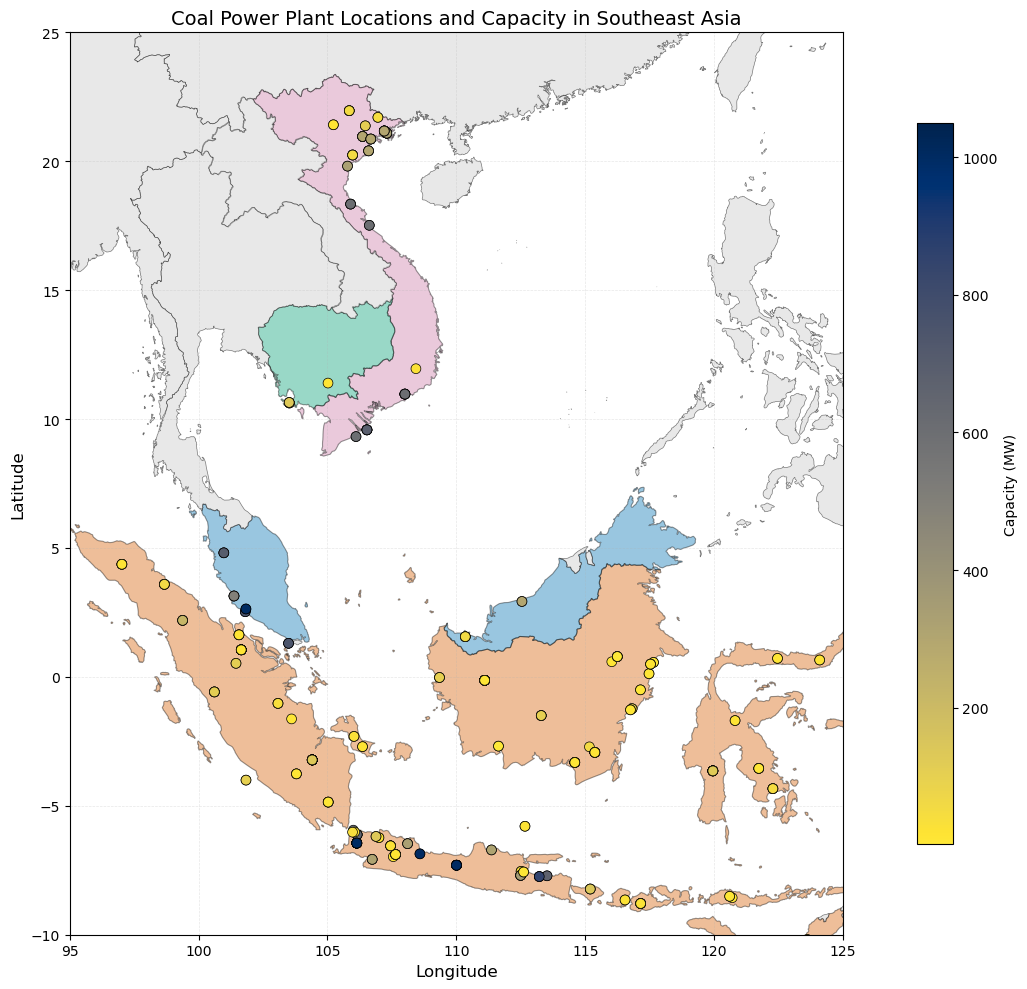

In [40]:
# Filter for plants with location data
plants_with_location = CGP_df[CGP_df['latitude'].notna() & CGP_df['longitude'].notna()].copy()

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Define colors for specific countries (matching your image)
country_colors =  {
        'Malaysia': '#0072B2',  
        'Cambodia': '#009E73',  
        'Indonesia': '#D55E00', 
        'Vietnam': '#CC79A7'    
    }

# Plot base map with country-specific colors
for idx, row in country_df.iterrows():
    if row['country'] in country_colors:
        # Plot highlighted countries with their specific colors
        geopandas.GeoSeries([row['geometry']]).plot(
            ax=ax, 
            color=country_colors[row['country']], 
            edgecolor='black', 
            linewidth=0.8,
            alpha = 0.4,
        )
    else:
        # Plot other countries in light gray
        geopandas.GeoSeries([row['geometry']]).plot(
            ax=ax, 
            color='lightgray', 
            edgecolor='black', 
            linewidth=0.5,
            alpha = 0.5
        )

# Set uniform size for all circles
uniform_size = 50  # Adjust this value to change circle size

# Plot plants as scatter points with uniform size
scatter = ax.scatter(
    plants_with_location['longitude'],
    plants_with_location['latitude'],
    s=uniform_size,  # All circles same size
    c=plants_with_location['MW_total'],  # Color by capacity
    cmap='cividis_r',
    edgecolors='black',
    linewidth=0.5,
    zorder=5
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Capacity (MW)', shrink=0.8)

# Set map extent to focus on Southeast Asia
ax.set_xlim(95, 125)  # Adjust longitude range as needed
ax.set_ylim(-10, 25)   # Adjust latitude range as needed

# Add labels and title
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Coal Power Plant Locations and Capacity in Southeast Asia', fontsize=14)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('../figures/talks/plant_locations_map.png', dpi=300, bbox_inches='tight')

# Print summary statistics
print(f"\nTotal plants plotted: {len(plants_with_location)}")
print(f"Total capacity: {plants_with_location['MW_total'].sum():.0f} MW")
print(f"Capacity range: {plants_with_location['MW_total'].min():.0f} - {plants_with_location['MW_total'].max():.0f} MW")
print(f"Number of plants by country:")
print(plants_with_location.groupby('COUNTRY')['MW_total'].agg(['count', 'sum']))